# Mak et al, 2015

## Introduction

In this notebook we will identify PPMI subjects to reproduce the following paper:

<div class="alert alert-block alert-success"> E. Mak et al., <a href="https://academic.oup.com/brain/article/138/10/2974/2468704?login=false" style="text-decoration: none;">“Baseline and longitudinal grey matter changes in newly diagnosed Parkinson’s disease: ICICLE-PD study,”</a> Brain, vol. 138, no. 10, pp. 2974–2986, 2015.
</div>

This study involved 105 subjects with newly diagnosed idiopathic Parkinson’s disease (PD) and 37 healthy matched controls. 

Among the 105 PD subjects, they classified 39 subjects as PD with mild cognitive impairment (PD-MCI) and 66 subjects as PD with no cognitive impairment (PD-NC).

The demographics and clinical characteristics were as follows (table extracted from the paper):

<img src="images/cohort_table.jpeg"/>

The subjects had a serial 3 T structural magnetic resonance imaging (MRI) scans with clinical and neuropsychological assessments at baseline and, at 18 months follow-up.

These MRI were processed with Freesurfer, an image processing software, to measure the cortical thickness and subcortical volumes at baseline and follow-up. 

The key result of the paper reveals that PD-MCI shows more extensive atrophy and greater percentage of cortical thinning compared to PD-NC, as illustrated below in Table 2 and Figure 2C (extracted from paper) respectively. 

<img src="images/change_in_subcortical_volumes.jpeg"/>

<figure>
    
<img src="images/change_in_cortical_thinning.jpg"/>

<figcaption>
    <b>Figure 2C. Vertex-wise comparisons of percentage change in cortical thinning over 18 months.</b>
    The colour bar shows the logarithmic scale of P-values (−log10). Lh = left hemisphere; Rh = right hemisphere.</figcaption>

</figure>


In this notebook, we aim at reproducing these results using the PPMI dataset.

## Importing modules

First, let's initialize the notebook by installing software dependencies and importing libraries that we're going to use.

In [1]:
import os
import sys
import csv
import rich
import getpass
import paramiko
import numpy as np
import pandas as pd
import livingpark_utils
import warnings
from pingouin import ancova
from rich.table import Table
from itertools import product
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from rich.console import Console
from itertools import combinations
from collections import namedtuple
from collections import defaultdict
from collections.abc import Iterable
from livingpark_utils import clinical
from livingpark_utils import download
from livingpark_utils.scripts import run
from livingpark_utils.dataset import ppmi
from livingpark_utils.maketal import maketal
import livingpark_utils.visualization as visualization
from statsmodels.stats.multicomp import pairwise_tukeyhsd

inputs_dir = os.path.join(os.getcwd(), "inputs/study_files")
outputs_dir = os.path.join(os.getcwd(), "outputs")
data_dir = os.path.join(os.getcwd(), "data")

utils = livingpark_utils.LivingParkUtils()
downloader = download.ppmi.Downloader(utils.study_files_dir)
utils.notebook_init()

warnings.filterwarnings("ignore")

This notebook was run on 2023-03-03 19:34:19 UTC +0000


## Cohort Preparation

The first step in reproducing the paper is to build a PPMI cohort that looks the closest to Table 1. For this, we will use PPMI Study Data files.

## PPMI study data files download

The required PPMI study files to build the cohort are:

|Files|Used to retrieve|
|:---|:---|
|Demographics | gender|
|Age at visit | age|
|Socio-Economics| years of education|
|Participant Status | PD subjects and healthy controls|
|Primary Clinical Diagnosis | subjects with no PD nor other neurological disorder |
|Cognitive Categorization | PD-MCI and PD-NC subjects| 
|PD Diagnosis History | disease duration| 
|MDS UPDRS Part III | Hoehn and Yahr scores|
|LEDD Concomitant Medication Log | LEDD scores|
|Montreal Cognitive Assessment MoCA | MoCA and MMSE scores|
|Geriatric Depression Scale Short Version | GDS scores|


We will use the LivingPark utils library to download these files from the notebook. 

In [2]:
required_files = [
    "Demographics.csv",
    "Age_at_visit.csv",
    "MDS_UPDRS_Part_III.csv",
    "Socio-Economics.csv",
    "LEDD_Concomitant_Medication_Log.csv",
    "Montreal_Cognitive_Assessment__MoCA_.csv",
    "PD_Diagnosis_History.csv",
    "Cognitive_Categorization.csv",
    "Participant_Status.csv",
    "Primary_Clinical_Diagnosis.csv",
    "Geriatric_Depression_Scale__Short_Version_.csv"
]

utils.get_study_files(required_files, default=downloader)

Download skipped: No missing files!


## LivingPark utility notebook download 

We will also import notebooks from LivingPark utils to clean data which produce the following files:

* <code>MRI_info.csv</code>: contains 3D T1-weighted images by visit
* <code>MDS_UPDRS_Part_III_clean.csv</code>: contains cleaned-up PDSTATE and PDTRTMNT

In [ ]:
from livingpark_utils.scripts import mri_metadata
run.mri_metadata()

In [ ]:
from livingpark_utils.scripts import pd_status
run.pd_status()

## Data Exploration

Now that we have all the required files, we will start by preparing the data for cohort matching.

We will also analyze the PPMI dataset in order to gain a better understanding of the demographics and clinical characteristics of the data.

In [3]:
# Styling visualization plots
plt.rcParams["figure.figsize"] = (16, 8)
plt.rcParams['axes.facecolor'] = '#F2F5F9'
plt.rcParams['axes.edgecolor'] = 'none'
plt.rcParams['axes.grid'] = False
plt.rcParams['grid.color'] = 'white'
plt.rcParams["figure.autolayout"] = True
color = '#2A2A2A'

### Demographics Characteristics

### Cohort Definition

First, we will extract participants defined as healthy controls and diagnosed with Parkinson's disease.

We obtain the following distribution of participants across the cohort in the PPMI dataset:

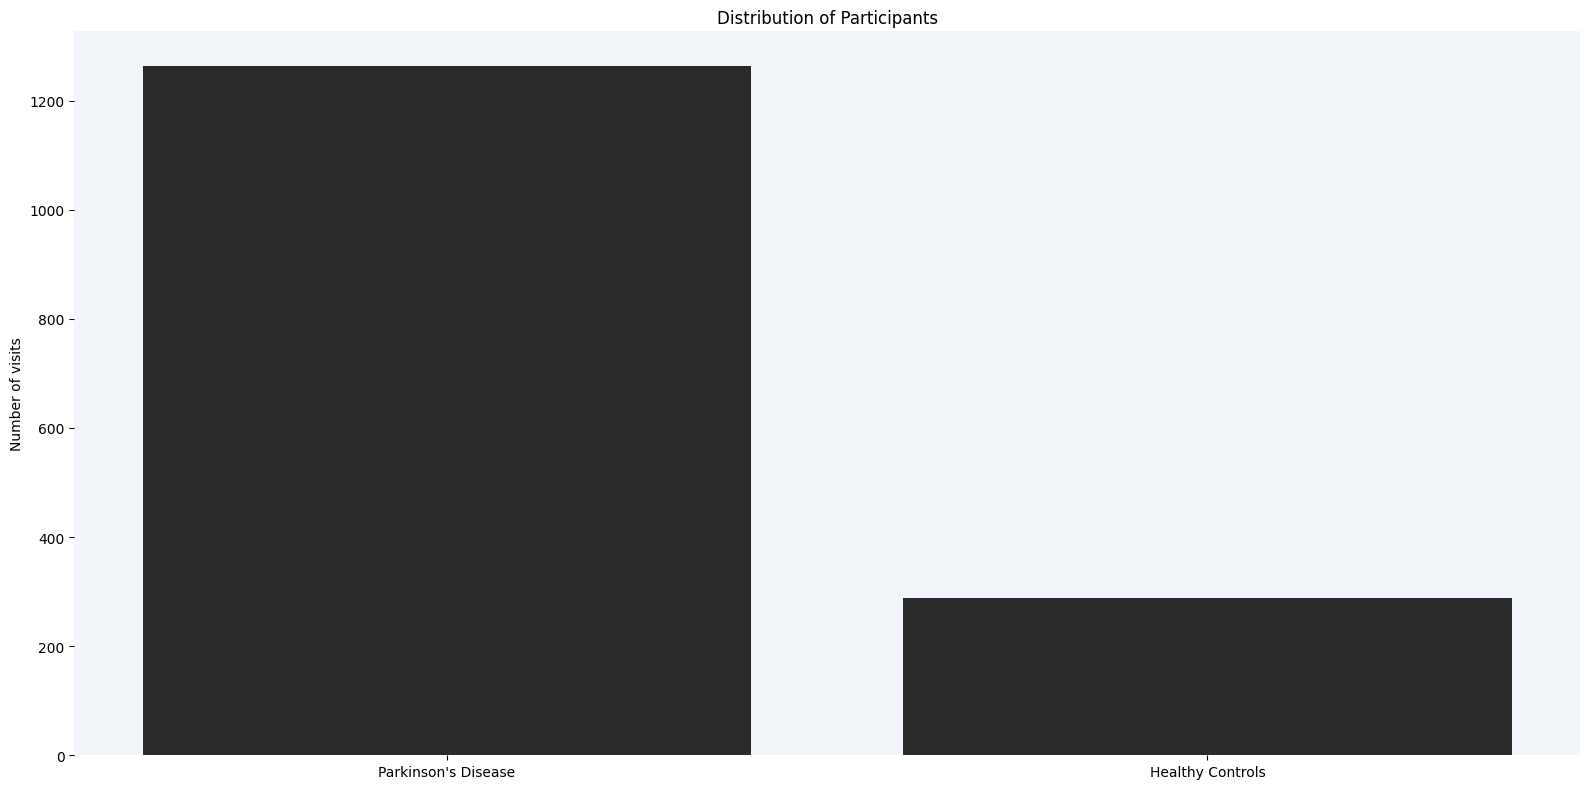

In [4]:
participants = pd.read_csv(os.path.join(inputs_dir, "Participant_Status.csv"), usecols=["PATNO", "COHORT"])
participants = participants[participants["COHORT"].isin([1, 2])] # Only keep PD(1) and HC(2).

pd_patients = participants[participants["COHORT"] == 1] # Dataframe with PD only
hc = participants[participants["COHORT"] == 2] # Dataframe with HC only

prim_diag = pd.read_csv(os.path.join(inputs_dir, "Primary_Clinical_Diagnosis.csv"), usecols=["PATNO", "PRIMDIAG"])

# Only keep no PD nor other neurological disorder (PRIMDIAG 17)
prim_diag = prim_diag[prim_diag["PRIMDIAG"].isin([17])].drop_duplicates()

# If patient status is both PRIMDIAG 17 and COHORT 2, 
# then patient is defined as healthy control
hc = hc.merge(prim_diag, on=["PATNO"]).drop_duplicates().drop(columns=['PRIMDIAG'])

# Merge PD, HC and PRIMDIAG
cohort_def = pd.concat([pd_patients, hc])
cohort_def = cohort_def.sample(frac=1, random_state=42)
cohort_def.drop_duplicates(subset=['PATNO'], keep='first', inplace=True)

cohort = cohort_def.groupby(["COHORT"]).size()
plt.bar(["Parkinson's Disease", "Healthy Controls"], cohort.values, color=color)
plt.ylabel("Number of visits")
plt.title("Distribution of Participants");

### Cognitive State

The original study differentiates between PD patients with and without MCI. 

We will consult PPMI's cognitive categorization to obtain its distribution. 

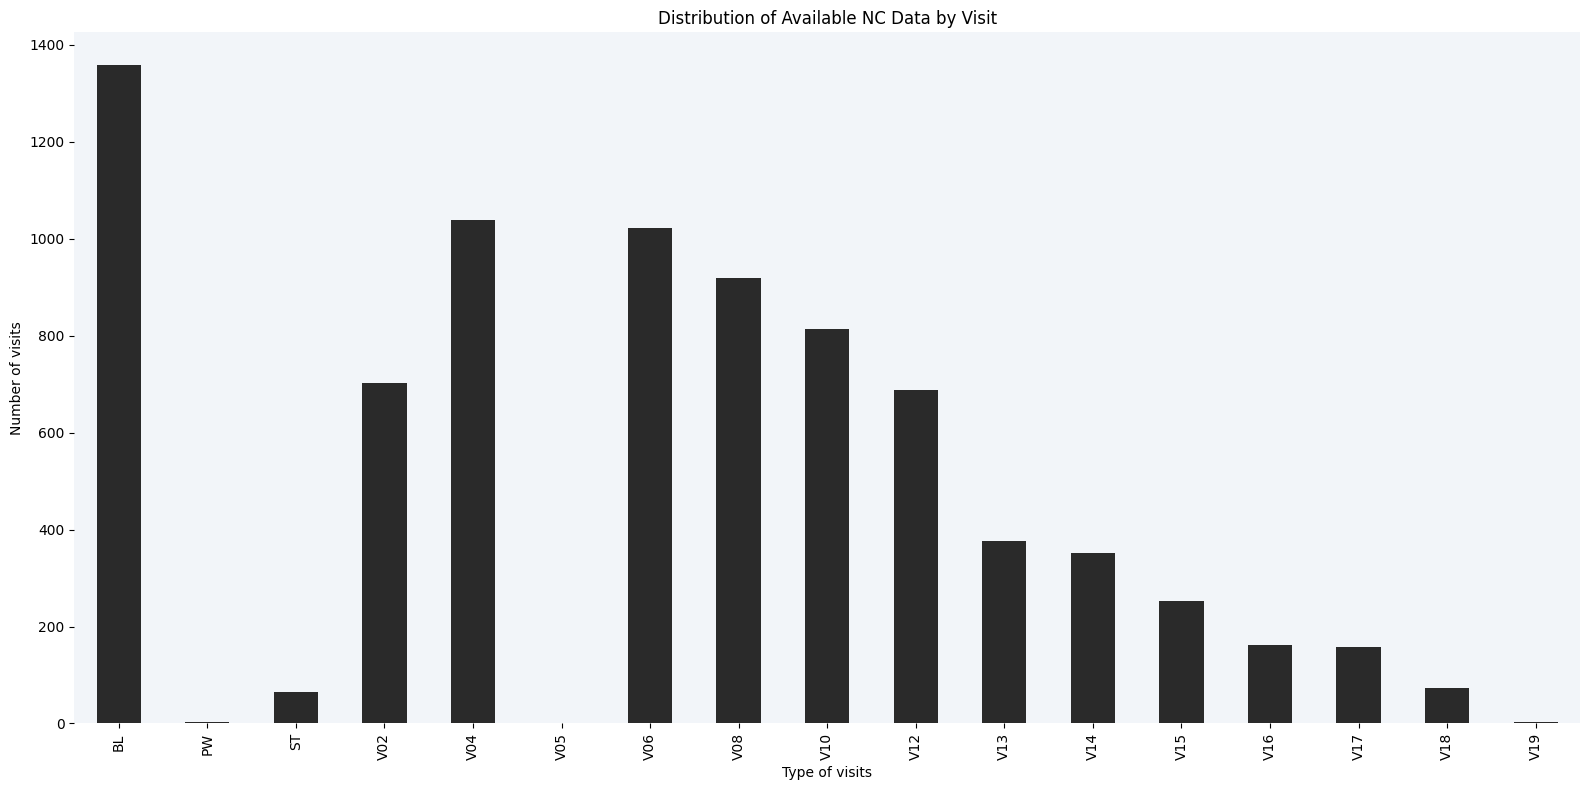

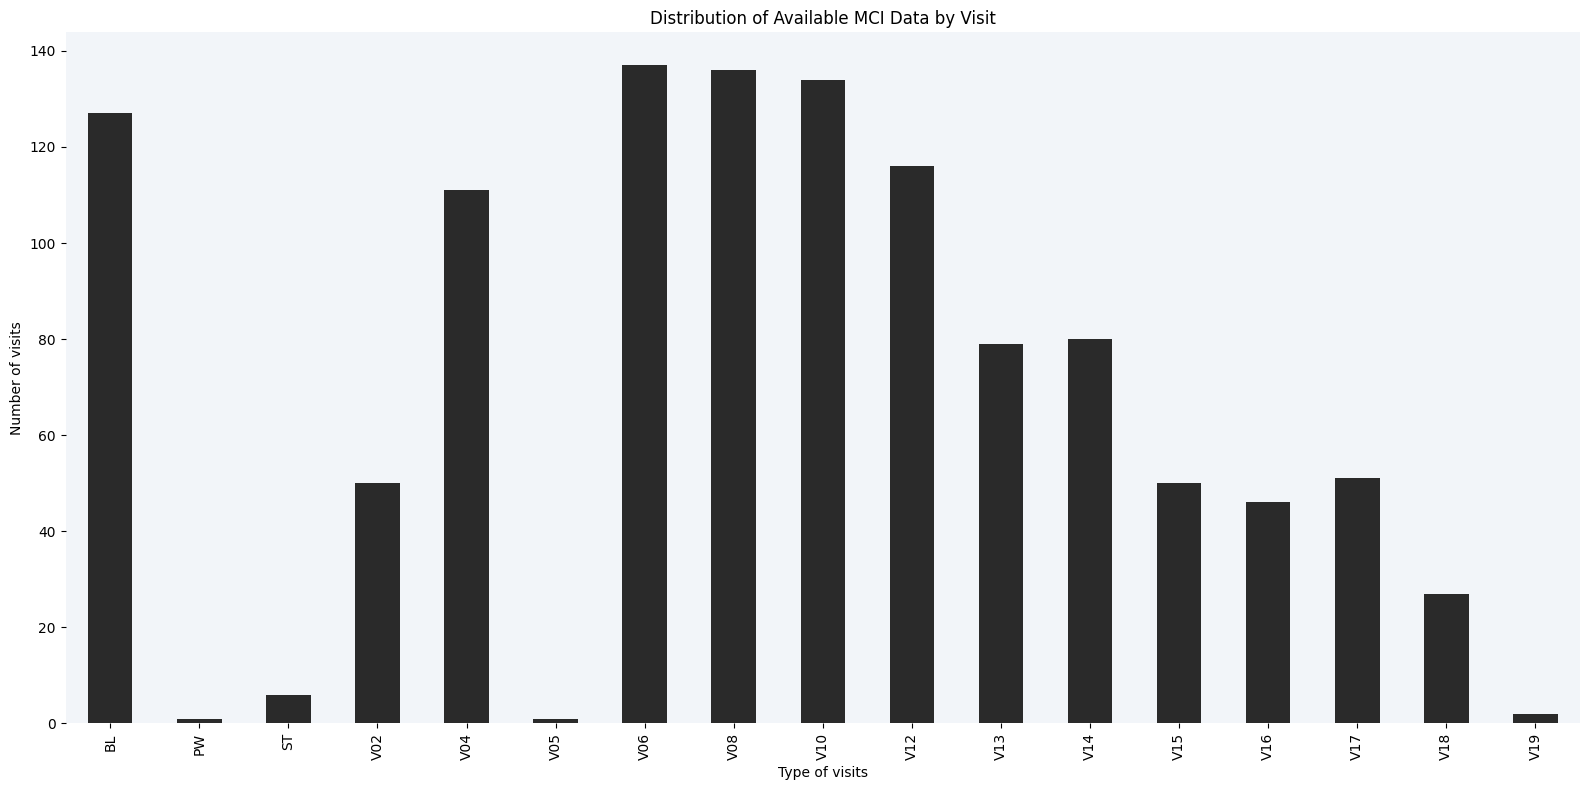

In [5]:
cogstate_df = pd.read_csv(os.path.join(inputs_dir,"Cognitive_Categorization.csv"),
                          usecols=["PATNO", "EVENT_ID", "COGSTATE"])
# Drop nan
cogstate_df = cogstate_df[cogstate_df["COGSTATE"].notna()] 
# Dropping all subjects with PDD
cogstate_df = cogstate_df[cogstate_df["COGSTATE"] != 3] 

cogstate = cogstate_df.groupby(["COGSTATE", "EVENT_ID"])["PATNO"].nunique().rename({1: "NC", 2: "MCI"})
shared_index = np.intersect1d(cogstate["NC"].index, cogstate["MCI"].index)
cogstate["NC"][shared_index].plot.bar(title="Distribution of Available NC Data by Visit", color=color)
plt.ylabel("Number of visits")
plt.xlabel("Type of visits")
plt.show()
cogstate["MCI"][shared_index].plot.bar(title="Distribution of Available MCI Data by Visit", color=color)
plt.ylabel("Number of visits")
plt.xlabel("Type of visits")
plt.show()

Types of visits expressed as: BL-Baseline, PW-Premature Withdrawal, ST-Symptomatic Therapy, V<em>xx</em>-Visit <em>xx</em>

The number of subjects with NC is significantly higher, as seen on the graphs above. Therefore, we will make sure to obtain MCI patients before NC ones.

### Age at visit

The patient's age was recorded at each visit. To keep it simple, we will only show the age distribution at baseline while considering the age at specific visits for the cohort.

Age range: 26.4 - 86.5
Average age: 62.87042594385285
Most common age: 63.3


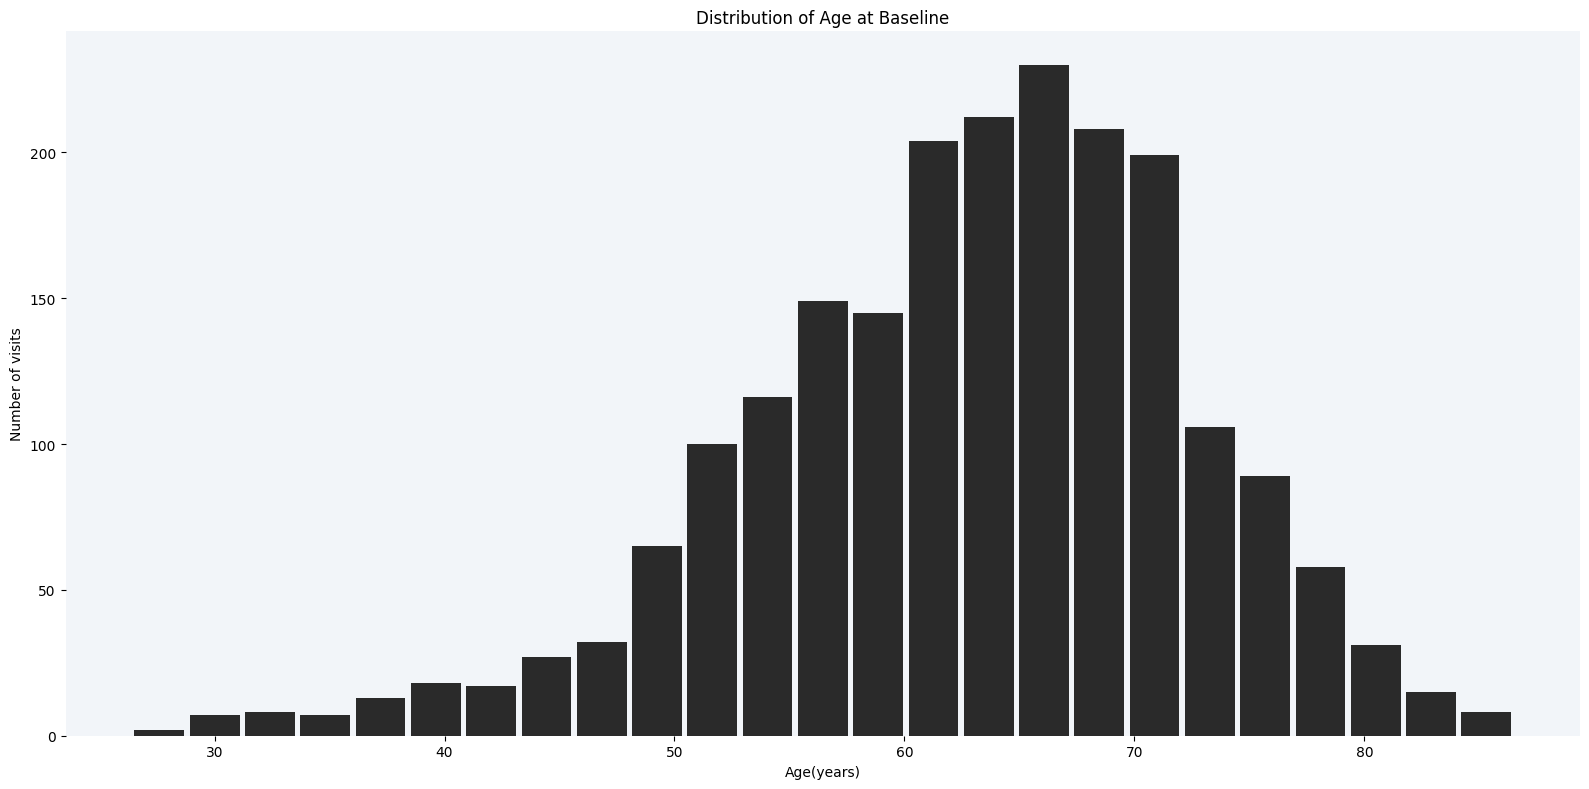

In [6]:
age_df = pd.read_csv(os.path.join(inputs_dir, "Age_at_visit.csv"),
                     usecols=["PATNO", "EVENT_ID", "AGE_AT_VISIT"])

age_df[age_df["EVENT_ID"] == "BL"]["AGE_AT_VISIT"].plot.hist(bins=25, color=color, rwidth=0.9);
plt.xlabel('Age(years)')
plt.ylabel('Number of visits')
plt.title("Distribution of Age at Baseline");

print("Age range:", age_df[age_df["EVENT_ID"] == "BL"]["AGE_AT_VISIT"].min(), "-", 
      age_df[age_df["EVENT_ID"] == "BL"]["AGE_AT_VISIT"].max())

print("Average age:",age_df[age_df["EVENT_ID"] == "BL"]["AGE_AT_VISIT"].mean())

print("Most common age:",age_df[age_df["EVENT_ID"] == "BL"]["AGE_AT_VISIT"].mode()[0])

The age of the subjects ranges from 26 to 86, with an average age of 62. The most common age among the subjects is 63.

### Gender

We will look at PPMI's demographics to get the gender distribution.

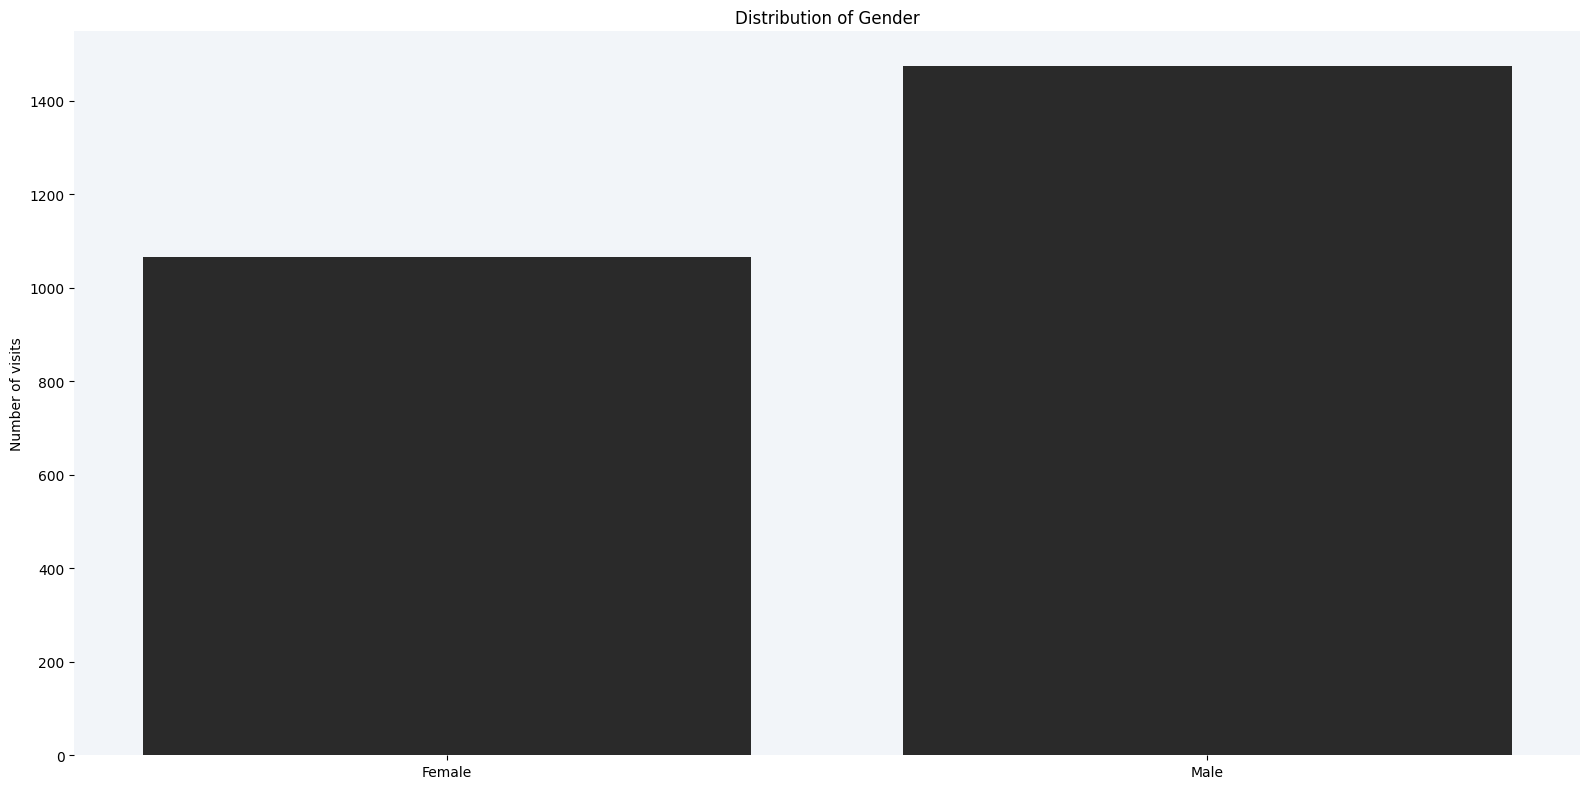

In [7]:
demo_df = pd.read_csv(os.path.join(inputs_dir,"Demographics.csv"), usecols=["PATNO", "SEX"])
demo_df["SEX"] = demo_df["SEX"].astype(int)

gender = demo_df.groupby("SEX").size().rename({0: "Female", 1: "Male"})

plt.bar(gender.index, gender.values, color=color)
plt.ylabel("Number of visits")
plt.title("Distribution of Gender");

There is a higher number of males than females in the study.

### Education

Looking at PPMI's socioeconomics, we obtain the following distribution by visit:

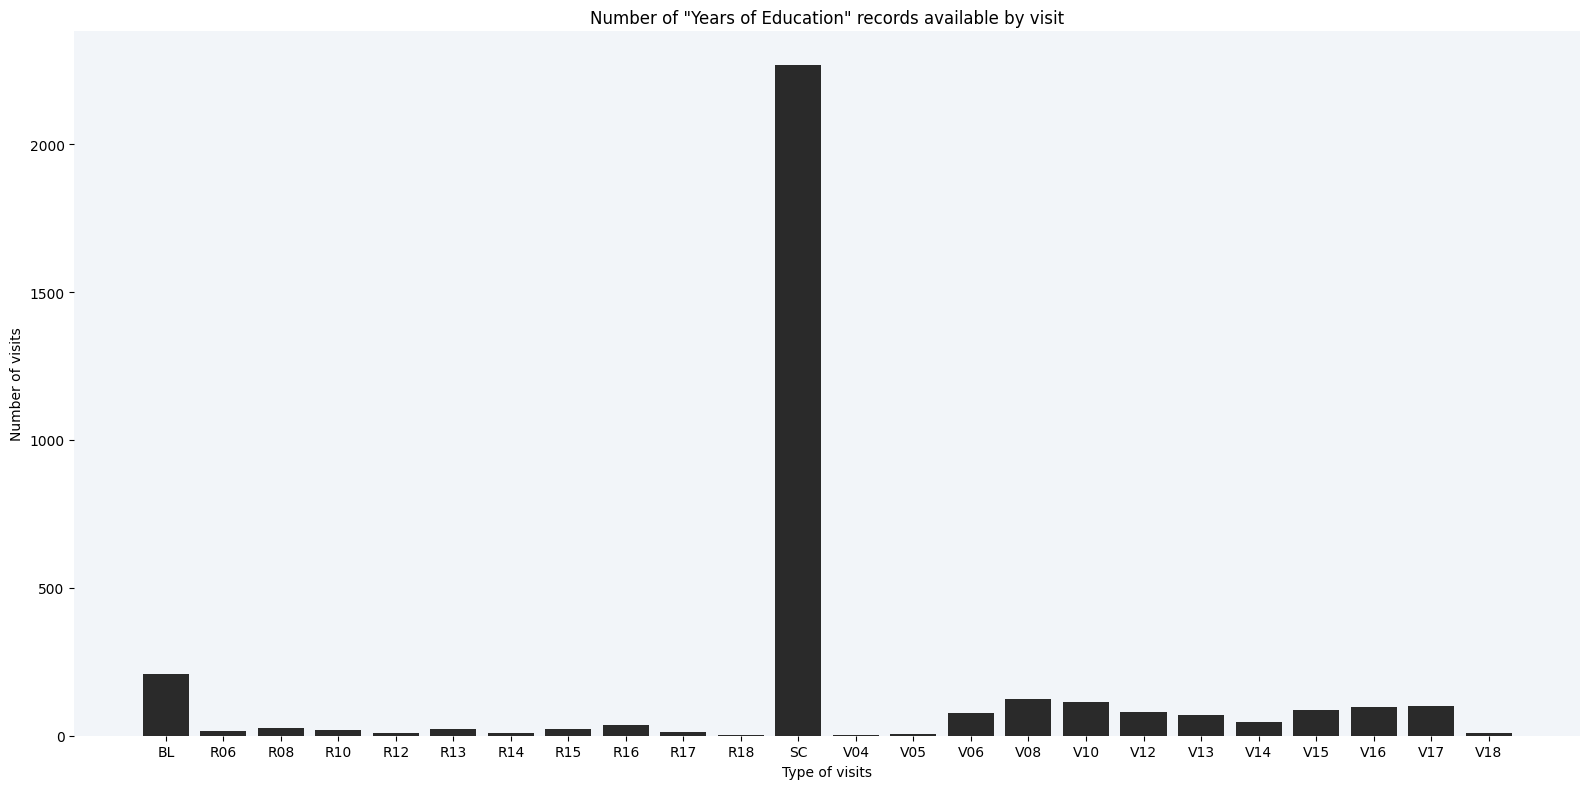

In [8]:
socioecon_df = pd.read_csv(os.path.join(inputs_dir,"Socio-Economics.csv"), usecols=["PATNO", "EVENT_ID", "EDUCYRS"])
events = socioecon_df.groupby("EVENT_ID").size()

plt.bar(events.index.astype(str), events.values, color=color)
plt.ylabel("Number of visits")
plt.xlabel("Type of visits")
plt.title("Number of \"Years of Education\" records available by visit");

We notice that in the above graph, the years of education were mostly recorded at screening. Thus, we will only consider the latter as the other visits might limit the possibility to perform data aggregation for the cohort matching.

We obtain the following distribution of years of education at screening:

Range of years of education: 0.0 - 30.0
Average years of education: 15.936936936936936


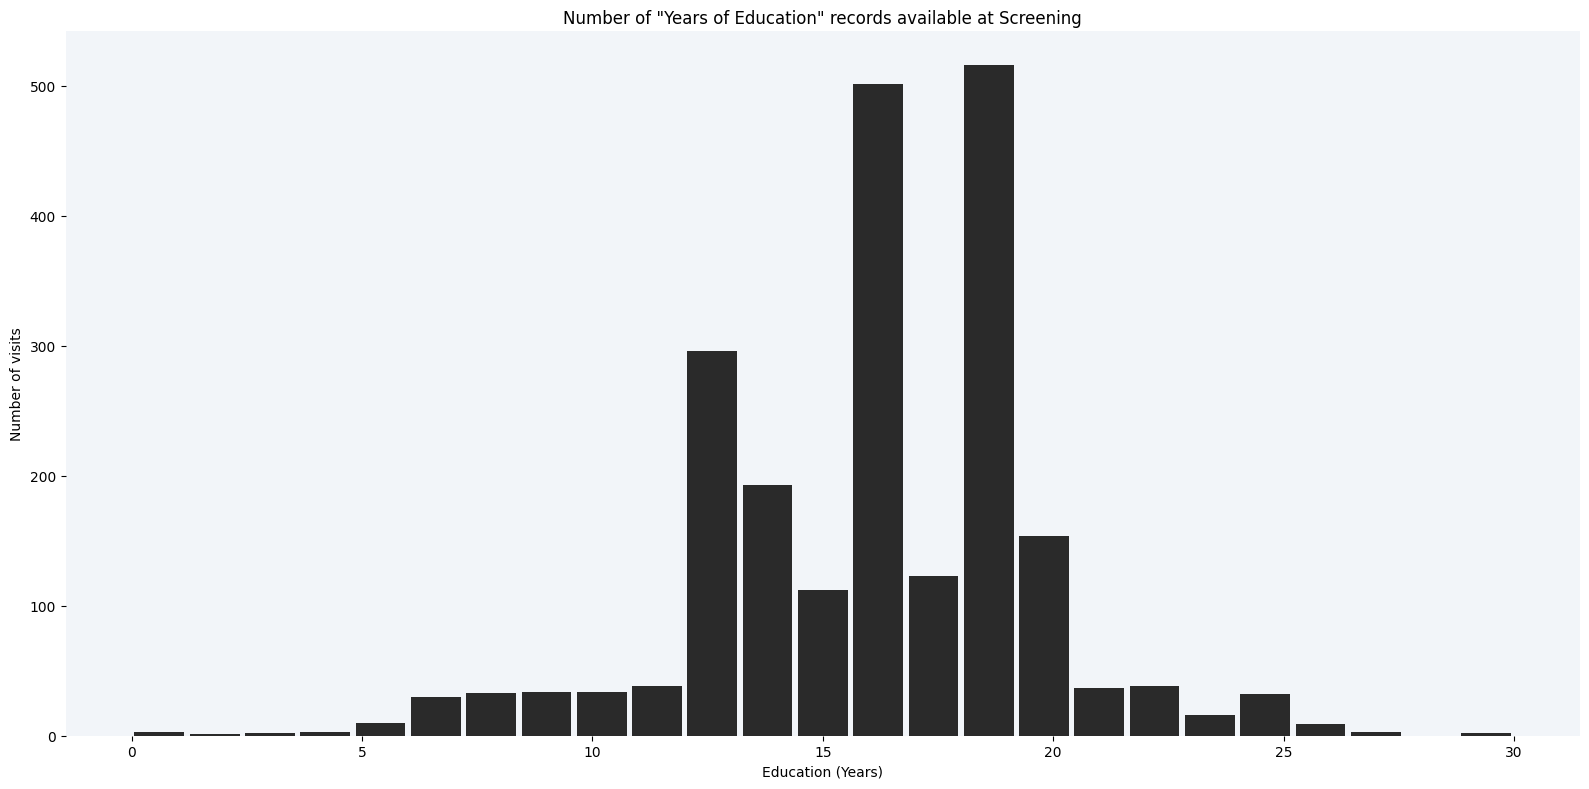

In [9]:
socioecon_df = socioecon_df[socioecon_df["EVENT_ID"] == "SC"]
socioecon_df = socioecon_df[["PATNO", "EDUCYRS"]]

socioecon_df["EDUCYRS"].plot.hist(bins=25, color=color, rwidth=0.9);
plt.ylabel("Number of visits")
plt.xlabel("Education (Years)")
plt.title("Number of \"Years of Education\" records available at Screening");

print("Range of years of education:", socioecon_df["EDUCYRS"].min(), "-", 
      socioecon_df["EDUCYRS"].max())

print("Average years of education:", socioecon_df["EDUCYRS"].mean())

The education levels of the subjects vary from 0 to 30 years, with an average of 15 years of education.

### Disease duration

Looking at the disease duration of the subjects, we obtain the following distribution by visit:

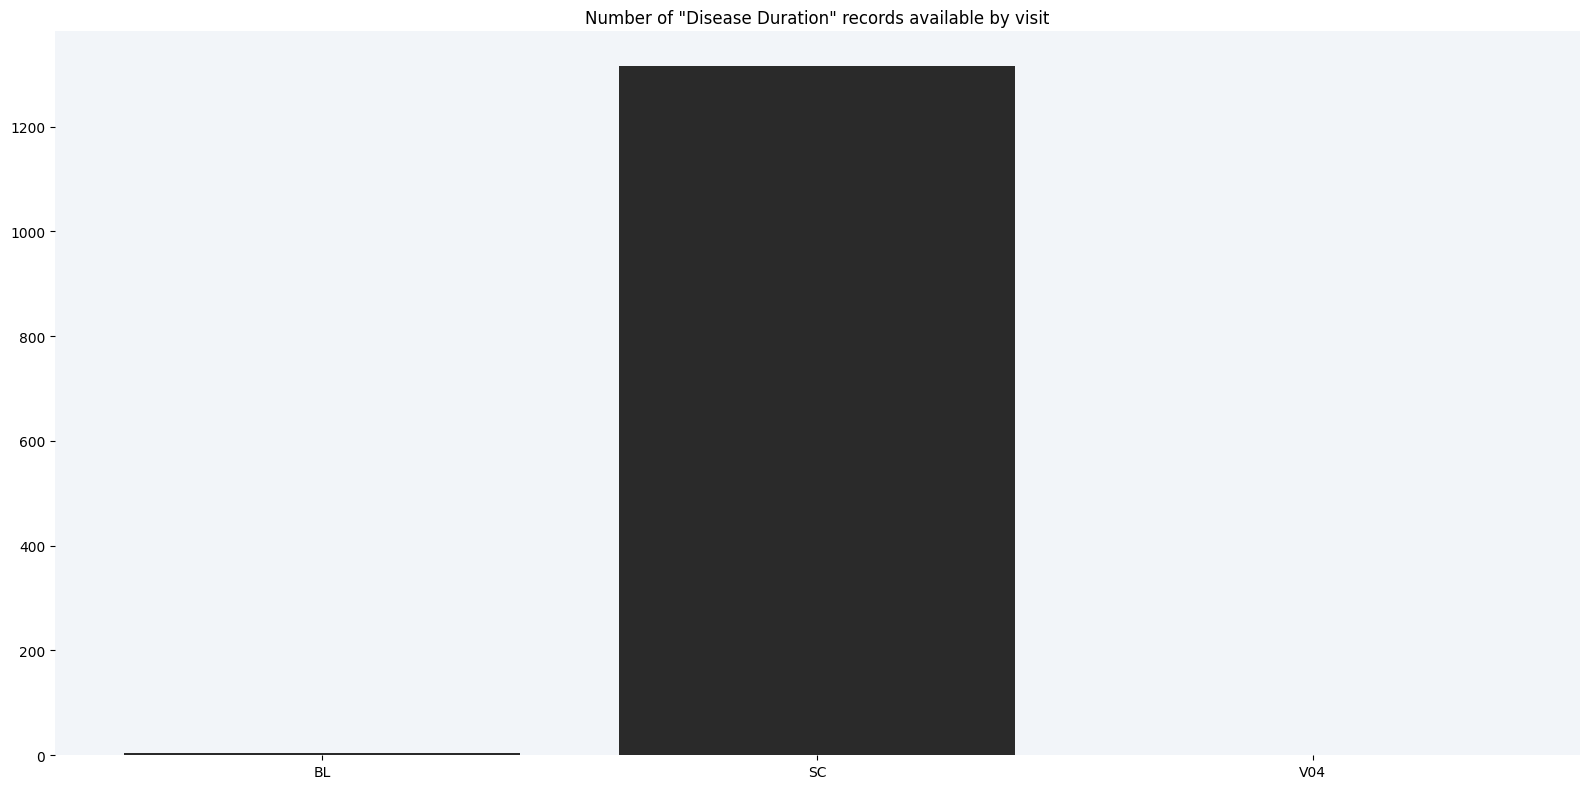

In [10]:
pddxdt_df = pd.read_csv(os.path.join(inputs_dir,"PD_Diagnosis_History.csv"), usecols=["PATNO", "EVENT_ID", "PDDXDT"])

events = pddxdt_df.groupby("EVENT_ID").size()

plt.bar(events.index.astype(str), events.values, color=color)
plt.title("Number of \"Disease Duration\" records available by visit");

Similar to the previous section, we will only use PD diagnosis duration taken at screening since it has the most records as shown in the graph above. 

We obtain the following distribution of disease duration:

Download skipped: No missing files!
Average duration of disease: 5.196050995024875
Most common disease duration: 2.0


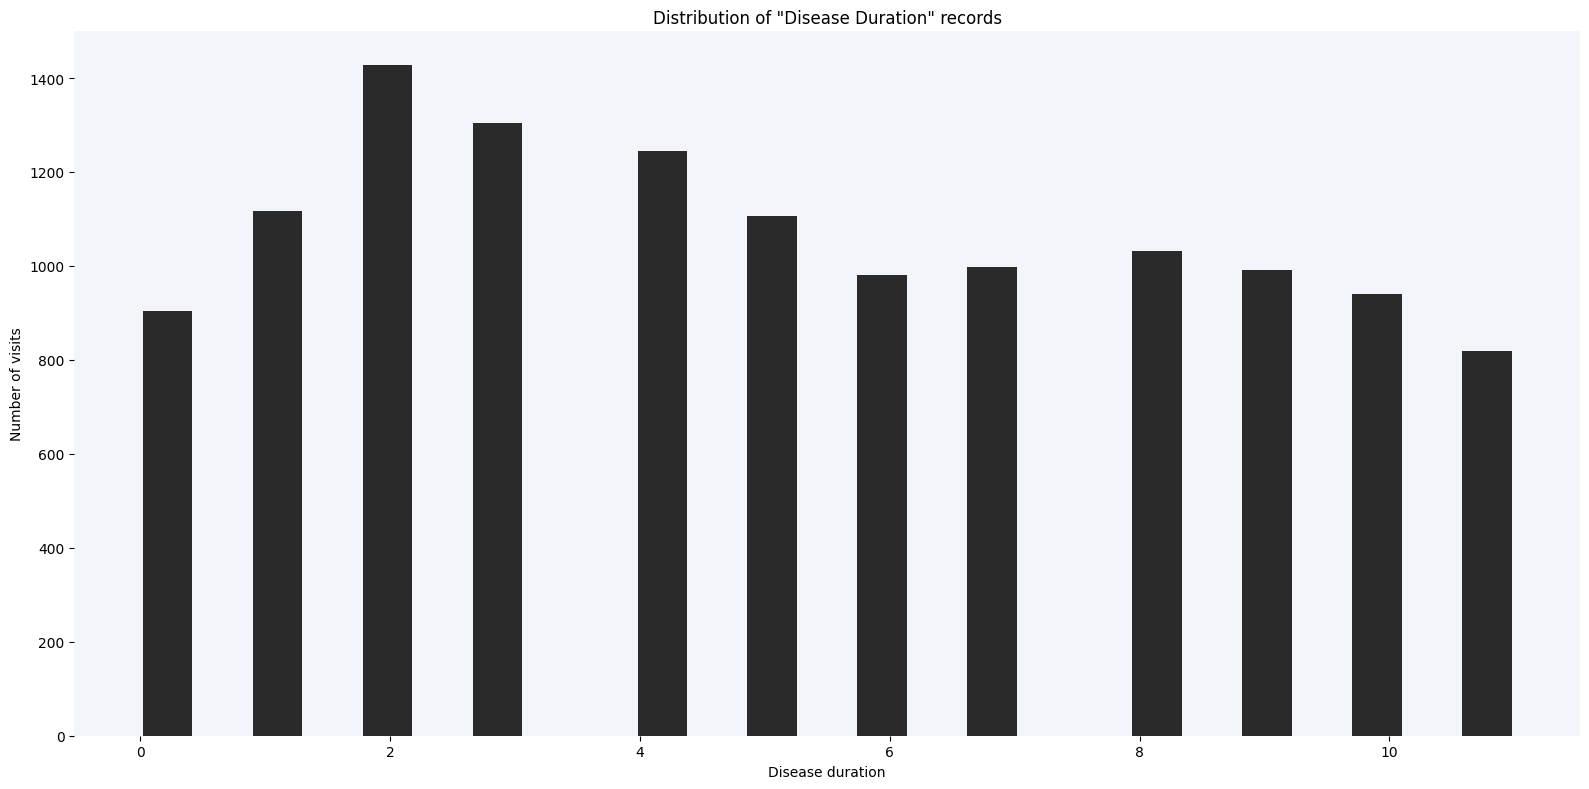

In [11]:
pdxdur_df = ppmi.disease_duration(inputs_dir)

pdxdur_df["PDXDUR"].plot.hist(bins=25, color=color, rwidth=0.9);
plt.ylabel("Number of visits")
plt.xlabel("Disease duration")
plt.title("Distribution of \"Disease Duration\" records");

print("Average duration of disease:", pdxdur_df["PDXDUR"].mean())
print("Most common disease duration:", pdxdur_df["PDXDUR"].mode()[0])

The average duration of the disease among the subjects is 5 months, with the most common disease duration being 2 months.

### Clinical Characteristics
### Levodopa equivalent daily dose (LEDD)

Analyzing the LEDD of the subjects, we observe the following distribution by visit: 

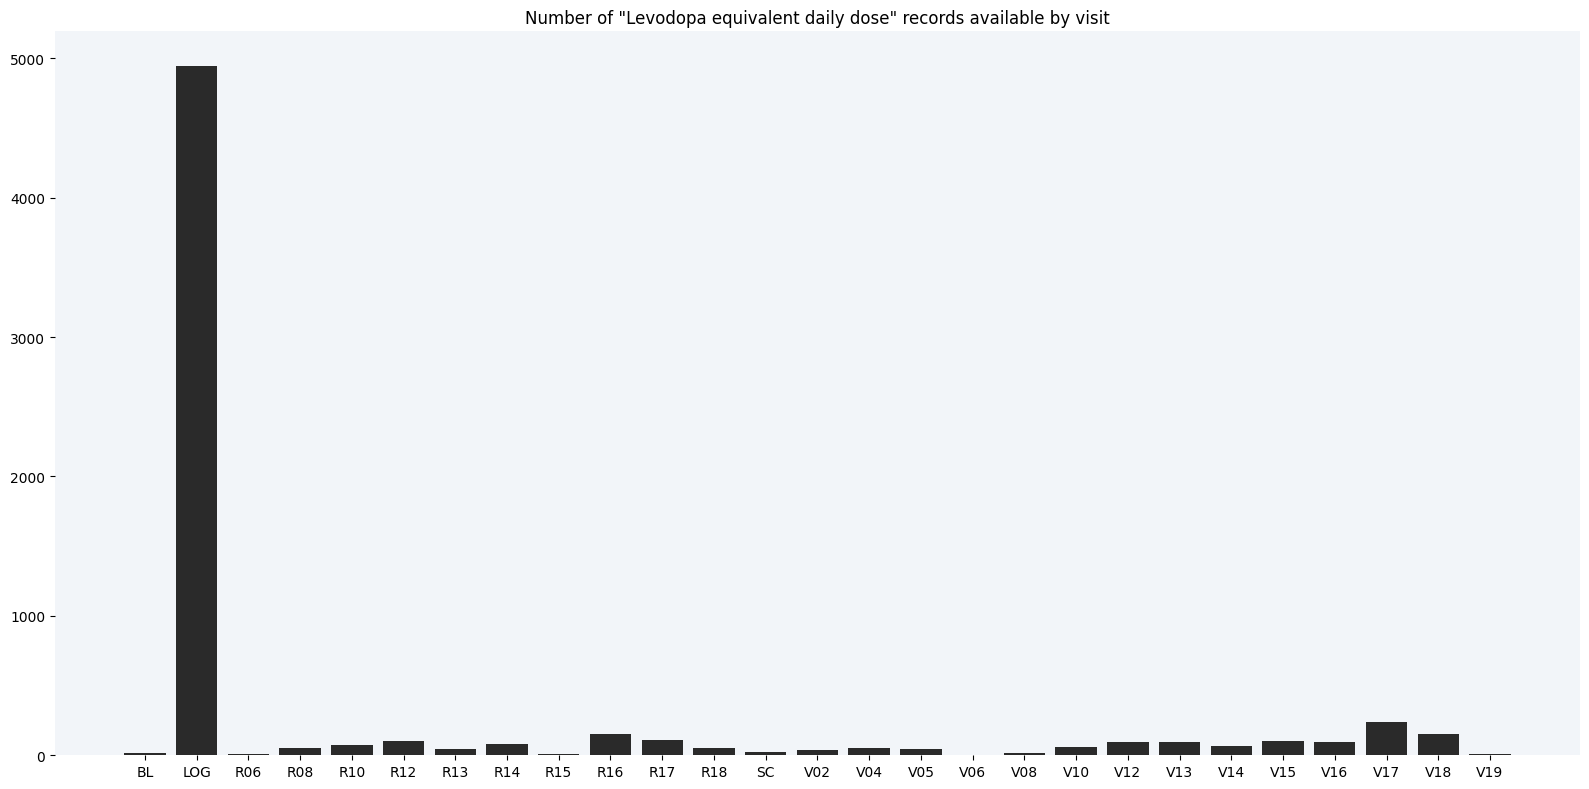

In [12]:
ledd_df = pd.read_csv(os.path.join(inputs_dir,"LEDD_Concomitant_Medication_Log.csv"),
                     usecols=["PATNO", "EVENT_ID", "LEDD"])

events = ledd_df.groupby(["EVENT_ID"]).size()
plt.bar(events.index.astype(str), events.values, color=color)
plt.title("Number of \"Levodopa equivalent daily dose\" records available by visit");

Likewise, as seen in the graph above, LEDD was mostly recorded at logs. Therefore, we will only consider LEDD at logs.

The distribution of LEDD is as follows:

Average LEDD dose: 264.99988
Most common LEDD dose: 100.0


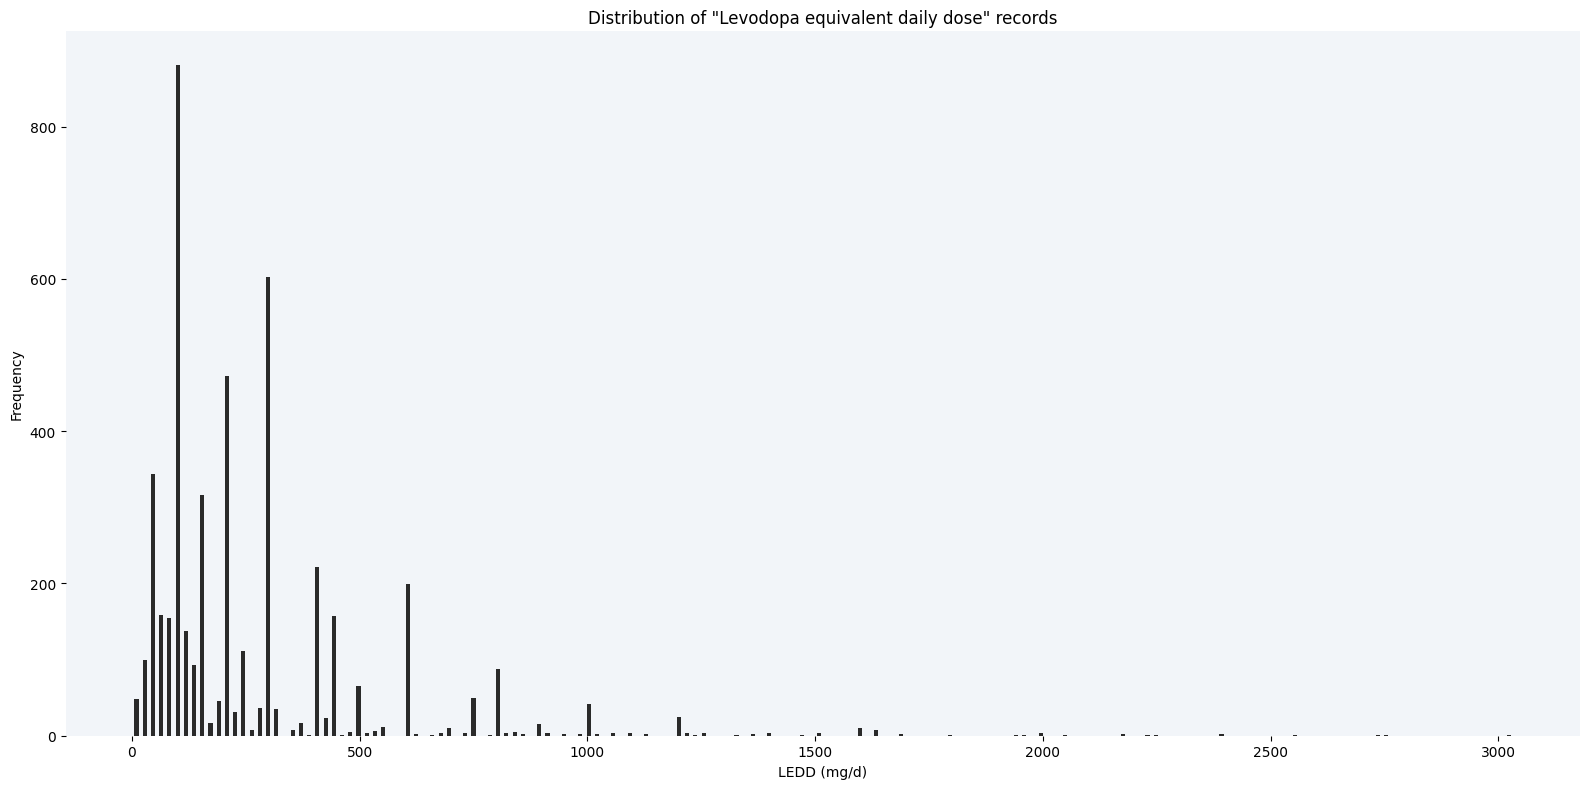

In [13]:
ledd_df = ledd_df[ledd_df["EVENT_ID"] == "LOG"]
ledd_df = ledd_df[["PATNO", "LEDD"]]

# For PD medications except COMT inhibitors, the column LEDD will show the value of the
# Levodopa equivalent dose for that medication. 

# For COMT inhibitors, the column LEDD will read “LD x 0.33” (for Entacapone) or “LD x 0.5” 
# (for Tolcapone). 

# To find the LEDD for COMT inhibitors, first find the total dose of Levodopa only, 
# and then multiply the Levodopa dose by either 0.33 or 0.5 as instructed. 

# Since Levodopa dose is mostly missing we will drop those.

ledd_df = ledd_df[ledd_df["LEDD"].notna()] # Drop nan
ledd_df = ledd_df[ledd_df["LEDD"] != "LD x 0.33"] # Drop LD x 0.33
ledd_df = ledd_df[ledd_df["LEDD"] != "LD x 0.5"] # Drop LD x 0.5

ledd_df["LEDD"] = ledd_df["LEDD"].astype('float32')

ledd = ledd_df.groupby(["LEDD"]).size()

plt.hist(ledd_df['LEDD'], zorder=3, color=color, bins=len(ledd.index),rwidth=0.5)
plt.xlabel('LEDD (mg/d)')
plt.ylabel('Frequency')
plt.title("Distribution of \"Levodopa equivalent daily dose\" records");

print("Average LEDD dose:", ledd_df['LEDD'].mean())
print("Most common LEDD dose:", ledd_df['LEDD'].mode()[0])

The average LEDD dose among the subjects is 264 mg/d, with the most common LEDD dose being 100 mg/d.

### Hoehn and Yahr staging (H&Y)

We obtain the following distribution of H&Y scores:

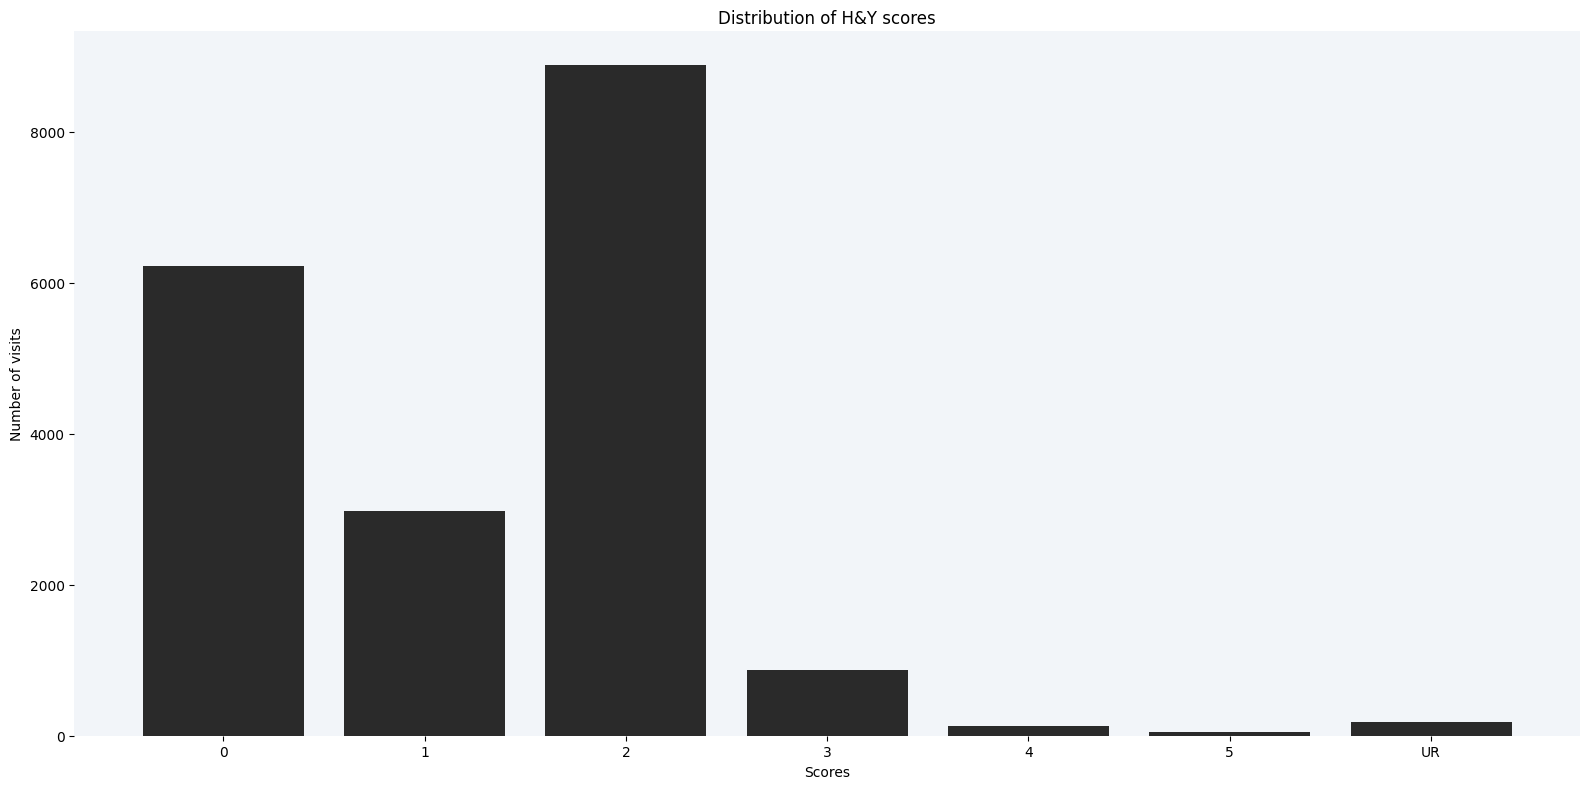

In [14]:
updrs3_df = pd.read_csv(os.path.join(inputs_dir,"MDS_UPDRS_Part_III_clean.csv"),
                     usecols=["PATNO", "EVENT_ID", "PDSTATE", "PDTRTMNT", "NP3TOT", "NHY"])
updrs3_df = updrs3_df[updrs3_df["NHY"].notna()] # Drop nan
updrs3 = updrs3_df.groupby(["NHY"], dropna=False).size()

plt.bar(updrs3.index.astype(str), updrs3.values, color=color)
plt.ylabel("Number of visits")
plt.xlabel("Scores")
plt.title("Distribution of H&Y scores");

As we can see, the most common H&Y score is 2 representing a bilateral or midline involvement without impairment of balance. 

UR is used to indicate that the examiners were unable to rate the H&Y score for some subjects. To ensure the reliability of our analysis, we will remove these subjects from our dataset.

In [15]:
# Remove UR patients
updrs3_df = updrs3_df[updrs3_df["NHY"] != "UR"]
updrs3_df["NHY"] = pd.to_numeric(updrs3_df["NHY"])

### Unified Parkinson’s Disease Rating Scale (UPDRS III)

We obtain the following distribution of UPDRS III scores:

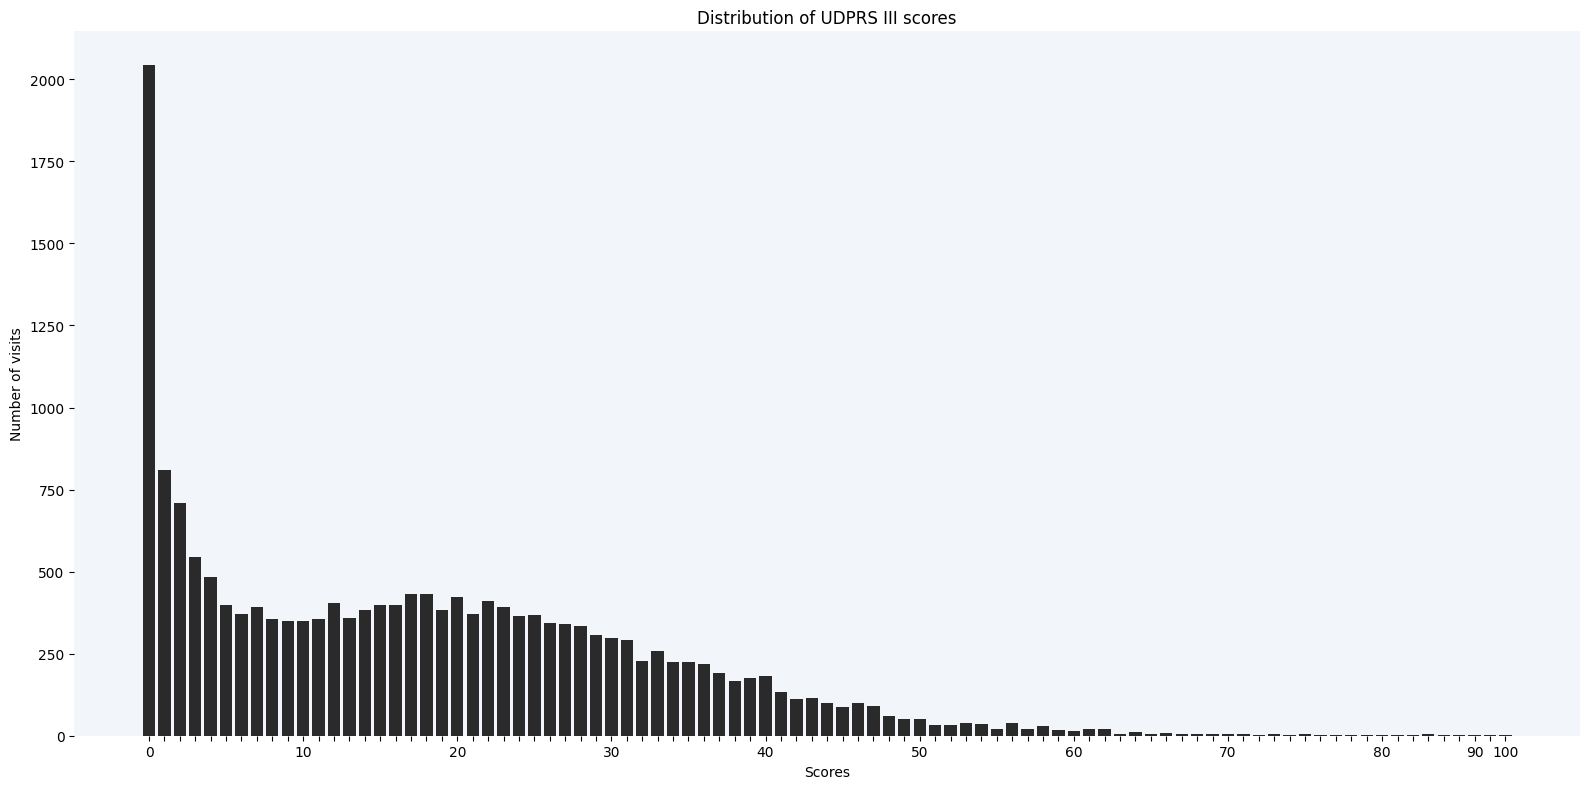

In [16]:
figure, ax = plt.subplots()

dist = updrs3_df.groupby(["NP3TOT"]).size()
plt.bar(dist.index.astype(str), dist.values, color=color)
plt.ylabel("Number of visits")
plt.xlabel("Scores")
plt.title("Distribution of UDPRS III scores")

visualization.reformat_plot_labels(dist, ax, 10)

The most common Unified Parkinson's Disease Rating Scale score among the subjects is 0 representing no disability.

### Montreal Cognitive Assessment (MoCA)

We obtain the following distribution of MoCA scores:

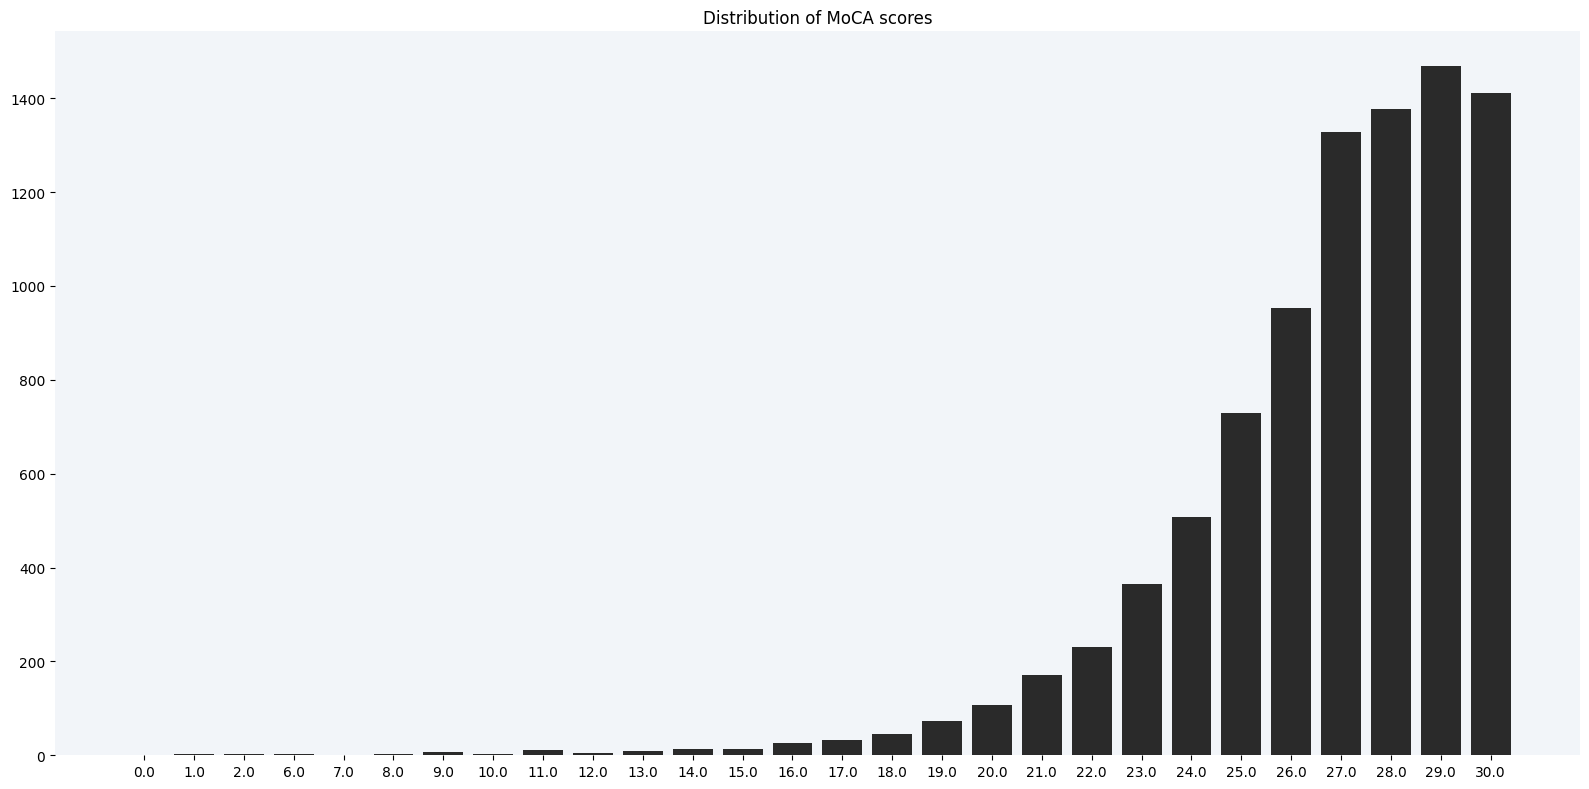

In [17]:
moca_df = pd.read_csv(os.path.join(inputs_dir,"Montreal_Cognitive_Assessment__MoCA_.csv"),
                   usecols=["PATNO", "EVENT_ID", "MCATOT","INFODT"])

# Use screening instead of baseline.
moca_df = moca_df[moca_df["EVENT_ID"] != "BL"]
moca_df["EVENT_ID"].mask(moca_df["EVENT_ID"] == "SC", "BL", inplace=True)
moca_df = moca_df.dropna()

moca = moca_df.groupby(["MCATOT"]).size()
plt.bar(moca.index.astype(str), moca.values, color=color)
plt.title("Distribution of MoCA scores");

The most common MoCA score among the subjects is 29 which is considered to be normal.

### Mini-Mental State Examination (MMSE)

We obtain the following distribution of MMSE scores:

0.0


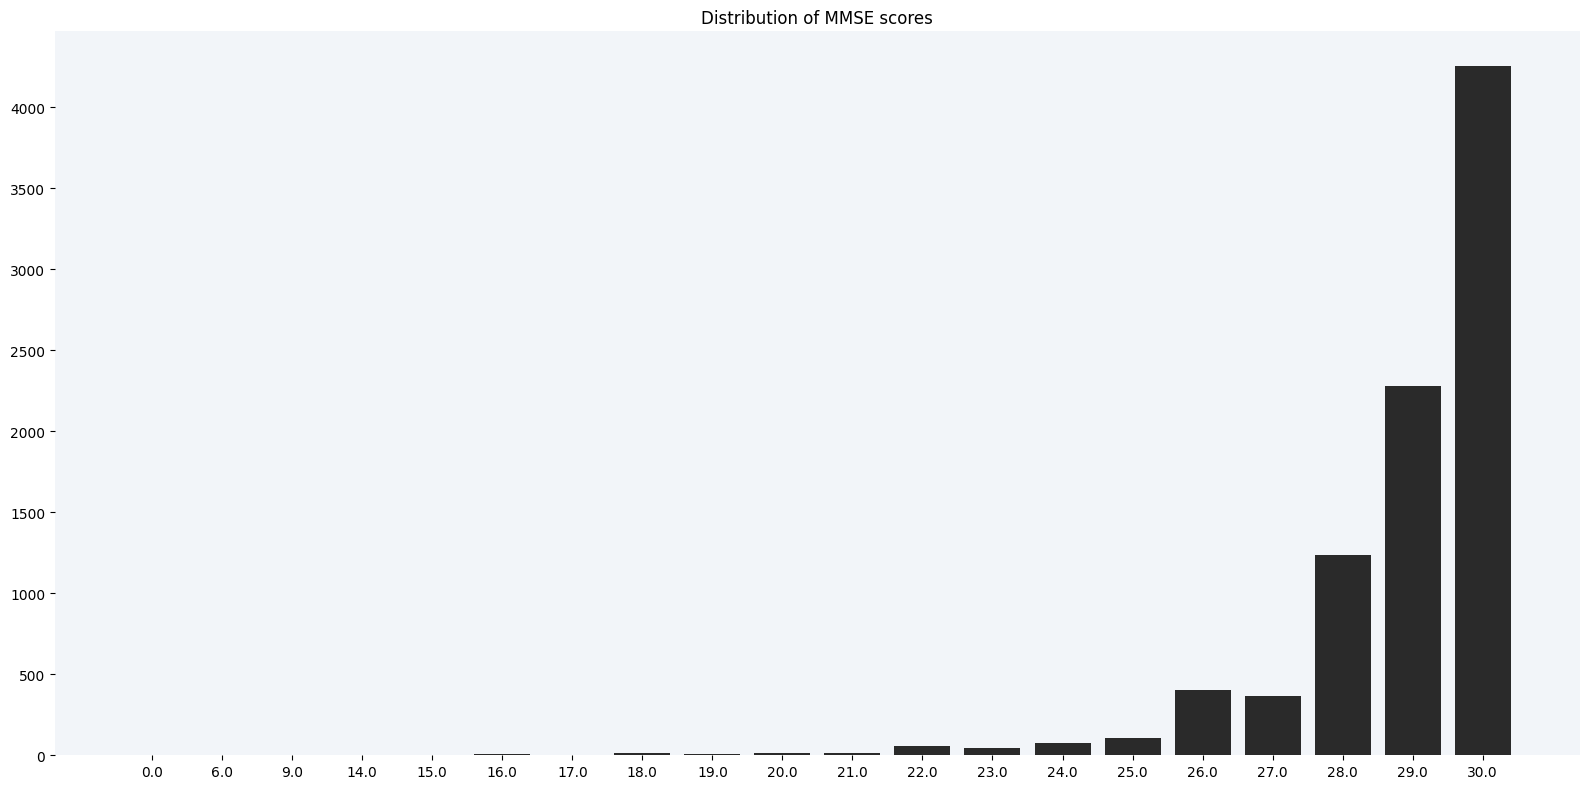

In [18]:
moca_df["MMSETOT"] = moca_df["MCATOT"].apply(clinical.moca2mmse)

mmse = moca_df.groupby(["MMSETOT"]).size()

plt.bar(mmse.index.astype(str), mmse.values, color=color)
plt.title("Distribution of MMSE scores");

The most common MMSE score among the subjects is 30 which is considered to be normal.

### Geriatric Depression Scale (GDS)

The original study used the GDS long form to calculate the GDS scores. However, GDS short form is only available in  PPMI. Therefore, the GDS scores will be out of 15 instead of 30. With this, we obtain the following distribution of GDS scores:

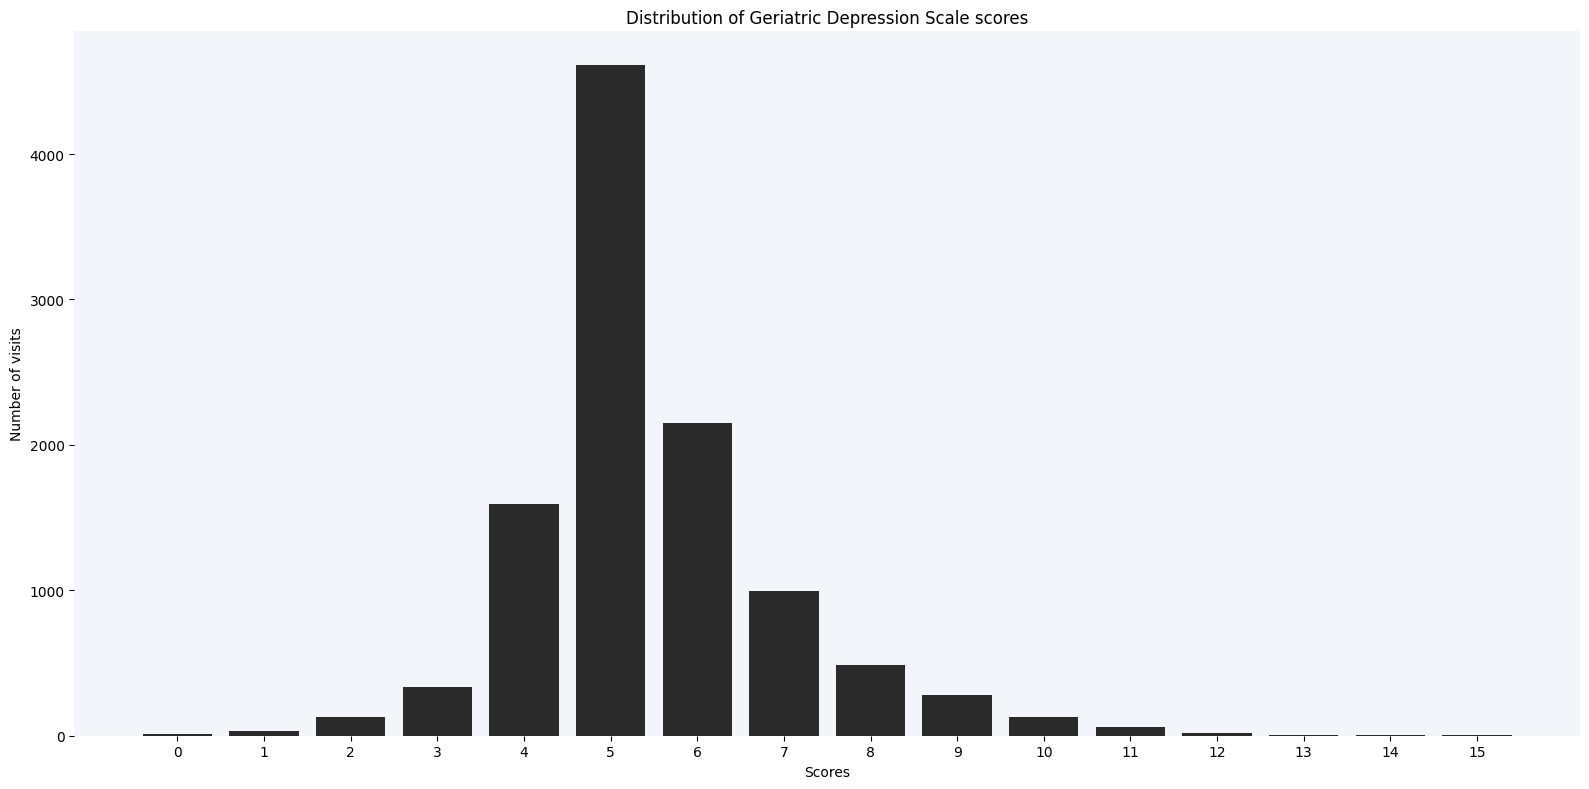

In [19]:
gdsshort_df = pd.read_csv(os.path.join(inputs_dir,"Geriatric_Depression_Scale__Short_Version_.csv"))
gdsshort_df = gdsshort_df.drop(["REC_ID","PAG_NAME", "INFODT","ORIG_ENTRY","LAST_UPDATE"], axis=1)

# Calculate GDS score for each patients
gds = gdsshort_df.iloc[:, 2:]
gds = gds.agg(['sum'], axis="columns").rename(columns={"sum": "GDSTOT"})

# Add gds score for each patients to DF
gdsshort_df = pd.concat([gdsshort_df[['PATNO', 'EVENT_ID']], gds], axis=1)

gds = gdsshort_df.groupby(["GDSTOT"]).size()

plt.bar(gds.index.astype(int).astype(str), gds.values, color=color)
plt.ylabel("Number of visits")
plt.xlabel("Scores")
plt.title("Distribution of Geriatric Depression Scale scores");

The most common GDS score among the subjects is 5 indicating mild depression.

### MRI Availabilty

So far we have gathered both demographics and clinical characteristics from the PPMI dataset, we need to make sure that there are enough MRI available to replicate the study. To check this, we will get the distribution of events based on MRI availability.

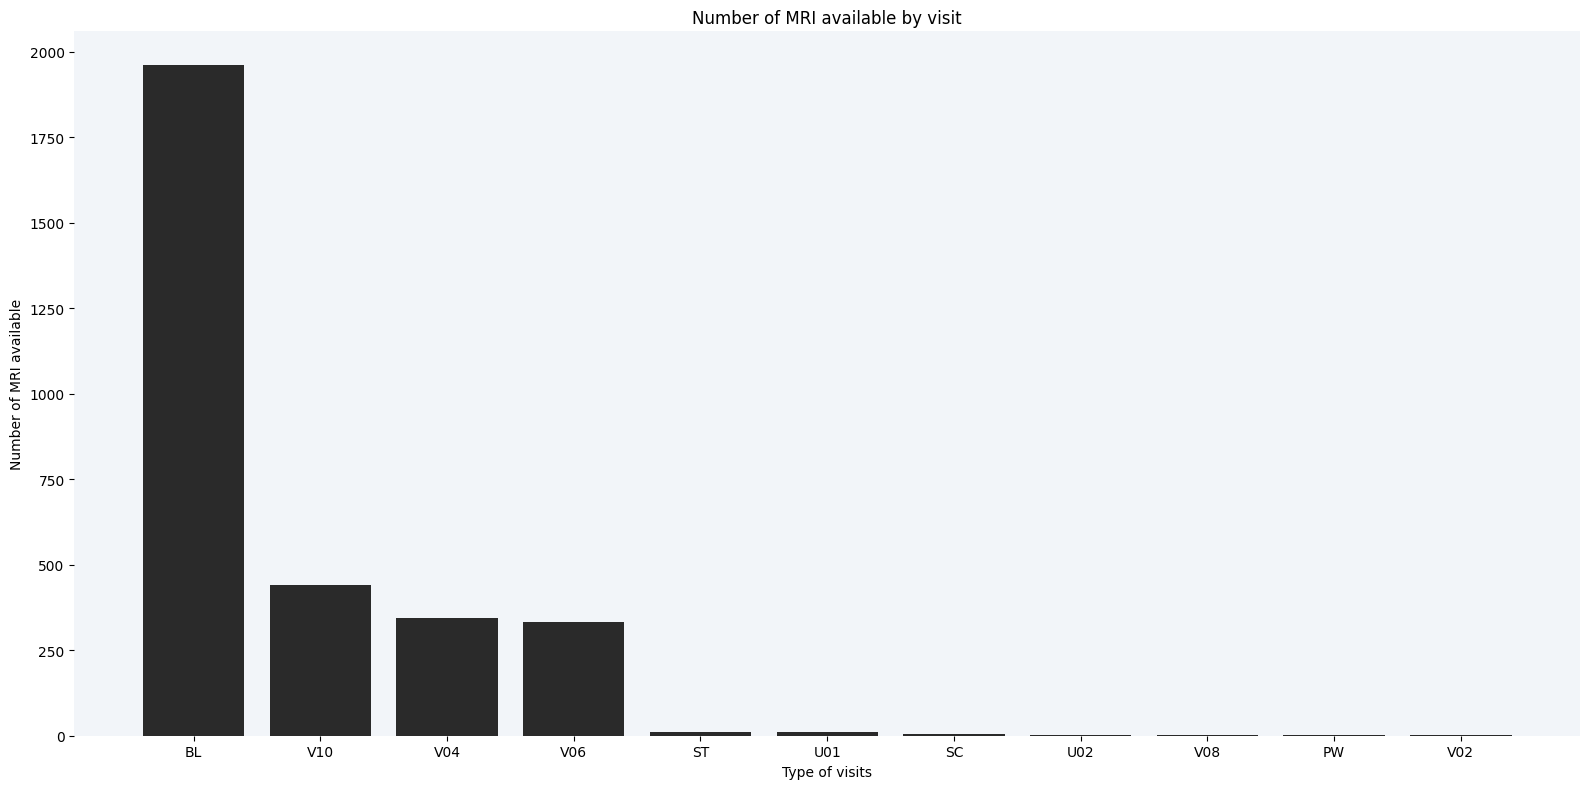

In [20]:
mri = pd.read_csv(os.path.join(inputs_dir,"MRI_info.csv"))
mri["EVENT_ID"] = mri["Visit code"]
mri["PATNO"] = mri["Subject ID"]
mri["Sex"] = mri["Sex"].map({"F": 0, "M": 1})
mri = mri.drop(
    ["Subject ID", "Visit code", "Visit", "Age", "Sex"], axis=1
)
mri_events = mri.groupby("EVENT_ID").size().sort_values(ascending=False)

plt.bar(mri_events.index, mri_events.values, color=color)
plt.ylabel("Number of MRI available")
plt.xlabel("Type of visits")
plt.title("Number of MRI available by visit");

As we can see in the graph above, BL (baseline), V10, V06 and V04 are the most frequent. Hence, we will only consider MRI with those visits.

## Data aggregation

Now that we have prepared all of our data, we will combine them into two respective dataframes, one for PD subjects and one for healthy controls.

Below is a summary of the number of subjects collected:

In [21]:
keys = ["PATNO", "EVENT_ID"]
pd_df = (
    cohort_def[cohort_def["COHORT"] == 1].merge(mri)
    .merge(cogstate_df, on=keys)
    .merge(age_df, on=keys)
    .merge(demo_df, on=["PATNO"])
    .merge(socioecon_df, on=["PATNO"])
    .merge(updrs3_df, on=keys)
    .merge(moca_df, on=keys)
    .merge(pdxdur_df, on=keys)
    .merge(ledd_df, on=["PATNO"])
    .merge(gdsshort_df, on=keys)
    .drop_duplicates()
    .groupby("PATNO")
    .filter(lambda g: g["EVENT_ID"].nunique() > 1)
)

hc_df = (
    cohort_def[cohort_def["COHORT"] == 2].merge(mri)
    .merge(age_df, on=keys)
    .merge(demo_df, on=["PATNO"])
    .merge(socioecon_df, on=["PATNO"])
    .merge(moca_df, on=keys)
    .merge(gdsshort_df, on=keys)
    .drop_duplicates()
)

nc_patno = pd_df[pd_df["COGSTATE"] == 1]["PATNO"]
mci_patno = pd_df[pd_df["COGSTATE"] == 2]["PATNO"]

In [22]:
print(f"Unique number of HC patients: {hc_df['PATNO'].nunique()}")
print(f"Unique number of NC patients: {nc_patno.nunique()}")
print(f"Unique number of MCI patients: {mci_patno.nunique()}")

Unique number of HC patients: 203
Unique number of NC patients: 147
Unique number of MCI patients: 47


### Acceptable visit pairs

To be able to replicate our cohort, we need subjects with follow-up scans. The original study followed up each subjects for 18 months. Below we will find the number of unique PD-MCI, PD-NC and HC subjects per visit pairs.

In [23]:
maketal.find_acceptable_visit_pairs(pd_df,hc_df)

Unique PD-MCI subjects per visit pairs:
BL  & V04 =   2 | Month difference:                 12
BL  & V06 =   3 | Month difference:                 24
BL  & V10 =   3 | Month difference:                 48
V04 & V06 =  12 | Month difference:                 12
V04 & V10 =   9 | Month difference:                 36
V06 & V10 =  16 | Month difference:                 24

Unique PD-NC subjects per visit pairs:
BL  & V04 =  31 | Month difference:                 12
BL  & V06 =  43 | Month difference:                 24
BL  & V10 =  39 | Month difference:                 48
V04 & V06 =  72 | Month difference:                 12
V04 & V10 =  63 | Month difference:                 36
V06 & V10 =  84 | Month difference:                 24

Unique HC subjects per visit pairs:
BL  & V04 =  63 | Month difference:                 12
BL  & V06 =   9 | Month difference:                 24
BL  & V08 =   2 | Month difference:                 36
BL  & V10 =  12 | Month difference:                 48
V04

Since the number of MCI subjects is quite low, we will focus on the pairs of visit that has the most number of MCI subjects, i.e, we will use a time interval of 12 and 24 months to replicate our cohort.

Now that the number of the months between baseline and follow-up is determined, we can now proceed to cohort matching.

## Cohort Summary

In [24]:
def cohort_summary(*, hc, nc, mci, title):
    def gen_row(D, *, agg, col, f="4.1f", sep=" ± "):
        if not isinstance(agg, str) and isinstance(agg, Iterable):
            return [f"{sep}".join([f"{d.loc[a][col]:{f}}" for a in agg]) for d in D]
        else:
            return [f"{d.loc[agg][col]:{f}}" for d in D]

    def gender_ratio(df):
        male_count = df[df["SEX"] == 1]["PATNO"].nunique()
        return f"{male_count:.0f}, {male_count / df['PATNO'].nunique() * 100:.1f}%"

    D = [hc.describe(), nc.describe(), mci.describe()]

    table = Table(title=title, box=rich.box.HORIZONTALS, show_footer=True, expand=True,
                  style="#cfd5e4", row_styles=["on #f2f5f9", ""])

    table.add_column( footer="Values expressed as mean ± SD.")
    table.add_column("Healthy Controls")
    table.add_column("PD-NC")
    table.add_column("PD-MCI")
#     table.add_column("[italic]P[not italic]-value")  # TODO
    
    table.add_row("n", *gen_row(D, agg="count", col="PATNO", f=".0f"))
    table.add_row("Age (y)", *gen_row(D, agg=["mean", "std"], col="AGE_AT_VISIT"))
    table.add_row(
        "Age range", *gen_row(D, agg=["min", "max"], col="AGE_AT_VISIT", sep=" - ")
    )
    table.add_row(
        "Gender (male, %)", gender_ratio(hc), gender_ratio(nc), gender_ratio(mci)
    )
    table.add_row("Education (y)", *gen_row(D, agg=["mean", "std"], col="EDUCYRS"))
    table.add_row(
        "Disease duration (mo)", "", *gen_row(D[1:], agg=["mean", "std"], col="PDXDUR")
    )
    table.add_row("LEDD (mg/d) baseline", "", *gen_row(D[1:], agg=["mean", "std"], col="LEDD"))
    table.add_row("LEDD (mg/d) follow-up", "", *gen_row(D[1:], agg=["mean", "std"], col="LEDD_NX"))
    table.add_row("H&Y baseline", "", *gen_row(D[1:], agg=["mean", "std"], col="NHY"))
    table.add_row("H&Y follow-up", "", *gen_row(D[1:], agg=["mean", "std"], col="NHY_NX"))
    table.add_row("UPDRS III baseline", "", *gen_row(D[1:], agg=["mean", "std"], col="NP3TOT"))
    table.add_row(
        "UPDRS III follow-up", "", *gen_row(D[1:], agg=["mean", "std"], col="NP3TOT_NX")
    )
    table.add_row("MMSE baseline", *gen_row(D, agg=["mean", "std"], col="MMSETOT"))
    table.add_row("MMSE follow-up", *gen_row(D, agg=["mean", "std"], col="MMSETOT_NX"))
    table.add_row("MoCA baseline", *gen_row(D, agg=["mean", "std"], col="MCATOT"))
    table.add_row("MoCA follow-up", *gen_row(D, agg=["mean", "std"], col="MCATOT_NX"))
    table.add_row("GDS baseline", *gen_row(D, agg=["mean", "std"], col="GDSTOT"))
    table.add_row("GDS follow-up", *gen_row(D, agg=["mean", "std"], col="GDSTOT_NX"))

    console = Console()
    console.print(table)

### Cohort with follow-up after 12 months

In [25]:
mci, nc, hc = maketal.create_cohort(pd_df=pd_df, hc_df=hc_df, months=12)

print(
    f"""Unique number of:
  - HC subjects:     {hc['PATNO'].unique().size} (/37)
  - PD-NC subjects:  {nc['PATNO'].unique().size} (/66)
  - PD-MCI subjects: {mci['PATNO'].unique().size} (/39)
"""
)

Unique number of:
  - HC subjects:     37 (/37)
  - PD-NC subjects:  64 (/66)
  - PD-MCI subjects: 13 (/39)



With a follow-up of 12 months, more than 60% of PD-MCI subjects are missing. 

In [26]:
cohort_summary(
    hc=hc,
    nc=nc,
    mci=mci,
    title="Demographic and clinical characteristics\n(12 months follow-up)",
)

                                     Demographic and clinical characteristics                                      
                                               (12 months follow-up)                                               
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
                                               Healthy Controls          PD-NC                 PD-MCI              
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  n                                            37                        64                    13                  
  Age (y)                                      60.5 ± 11.2               60.8 ±  9.1           65.3 ±  8.5         
  Age range                                    32.3 - 79.8               38.3 - 78.3           50.4 - 72.7         
  Gender (male, %)                             24, 64.9%                 39, 60.9%             9, 69.2%            
  Education (y)                                15.8 ±  3.1               15.3 ±  2.7           15.1 ±  2.9         
  Disease duration (mo)                                                   4.2 ±  2.9            4.8 ±  4.0         
  LEDD (mg/d) baseline                                                   263.8 ± 220.9         265.8 ± 145.1       
  LEDD (mg/d) follow-up                                                  263.8 ± 220.9         265.8 ± 145.1       
  H&Y baseline                                                            1.7 ±  0.6            1.8 ±  0.6         
  H&Y follow-up                                                           1.7 ±  0.5            1.7 ±  0.5         
  UPDRS III baseline                                                     19.1 ±  8.6           21.0 ± 12.2         
  UPDRS III follow-up                                                    20.4 ±  9.9           25.3 ± 12.8         
  MMSE baseline                                29.6 ±  0.5               29.3 ±  1.0           28.2 ±  1.1         
  MMSE follow-up                               29.3 ±  0.9               29.3 ±  1.0           28.4 ±  1.4         
  MoCA baseline                                28.2 ±  1.2               27.4 ±  2.2           25.1 ±  2.3         
  MoCA follow-up                               27.5 ±  2.2               27.4 ±  2.2           25.6 ±  2.8         
  GDS baseline                                  5.3 ±  1.5                5.4 ±  1.4            5.5 ±  1.2         
  GDS follow-up                                 4.8 ±  1.1                5.4 ±  1.7            5.6 ±  1.7         
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  Values expressed as mean ± SD.                                                                                   
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 

### Cohort with follow-up after 24 months

In [27]:
mci_, nc_, hc_ = maketal.create_cohort(pd_df=pd_df, hc_df=hc_df, months=24)

print(
    f"""Unique number of:
  - HC subjects:     {hc_['PATNO'].unique().size} (/37)
  - PD-NC subjects:  {nc_['PATNO'].unique().size} (/66)
  - PD-MCI subjects: {mci_['PATNO'].unique().size} (/39)
"""
)

Unique number of:
  - HC subjects:     9 (/37)
  - PD-NC subjects:  64 (/66)
  - PD-MCI subjects: 18 (/39)



With a follow-up of 24 months, 75% of Healthy Controls and more than 50% of PD-MCI subjects are missing.

In [28]:
cohort_summary(
    hc=hc_,
    nc=nc_,
    mci=mci_,
    title="Demographic and clinical characteristics\n(24 months follow-up)",
)

                                     Demographic and clinical characteristics                                      
                                               (24 months follow-up)                                               
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
                                               Healthy Controls          PD-NC                 PD-MCI              
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  n                                            9                         64                    18                  
  Age (y)                                      54.6 ± 15.5               62.9 ±  9.1           65.8 ±  8.7         
  Age range                                    30.6 - 76.8               38.3 - 82.3           49.9 - 79.2         
  Gender (male, %)                             6, 66.7%                  38, 59.4%             16, 88.9%           
  Education (y)                                14.2 ±  4.3               16.2 ±  2.6           14.6 ±  2.5         
  Disease duration (mo)                                                   4.6 ±  2.7            5.1 ±  3.2         
  LEDD (mg/d) baseline                                                   243.9 ± 187.8         243.5 ± 221.3       
  LEDD (mg/d) follow-up                                                  243.9 ± 187.8         243.5 ± 221.3       
  H&Y baseline                                                            1.8 ±  0.5            1.9 ±  0.2         
  H&Y follow-up                                                           1.9 ±  0.7            2.1 ±  0.7         
  UPDRS III baseline                                                     22.1 ± 11.0           26.6 ± 11.5         
  UPDRS III follow-up                                                    26.2 ± 14.7           27.9 ± 13.7         
  MMSE baseline                                29.8 ±  0.4               29.3 ±  1.0           28.5 ±  0.7         
  MMSE follow-up                               29.8 ±  0.4               29.3 ±  1.0           28.3 ±  1.4         
  MoCA baseline                                29.0 ±  1.2               27.6 ±  2.2           25.6 ±  1.6         
  MoCA follow-up                               28.7 ±  1.1               27.5 ±  2.2           25.3 ±  2.6         
  GDS baseline                                  5.1 ±  0.6                5.3 ±  1.5            6.1 ±  2.0         
  GDS follow-up                                 5.0 ±  0.5                5.2 ±  1.2            5.8 ±  1.4         
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  Values expressed as mean ± SD.                                                                                   
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 

### Cohort follow up after both 12 and 24 months

Since the two previous cohorts are no where near the original paper's cohort, we will try to merge subjects with both a follow-up of 12 and 24 months in one cohort.

In [29]:
# Merging PD-MCI
mci_mix = pd.concat([mci, mci_])
mci_mix = mci_mix.sample(frac=1, random_state=42)
mci_mix.drop_duplicates(subset=['PATNO'], keep='first', inplace=True)

# Merging PD-NC
nc_mix = pd.concat([nc, nc_])
nc_mix = nc_mix.sample(frac=1, random_state=42)
nc_mix.drop_duplicates(subset=['PATNO'], keep='first', inplace=True)

# Merging HC subjecs
hc_mix = pd.concat([hc, hc_])
hc_mix = hc_mix.sample(frac=1, random_state=42)
hc_mix.drop_duplicates(subset=['PATNO'], keep='first', inplace=True)

# Removing subjects that appears in more than one group
pd_mix = pd.concat([mci_mix, nc_mix])
duplicates = pd_mix[pd_mix.duplicated(['PATNO'])].index
nc_mix.drop(index=duplicates, inplace=True)

hc_mix = hc_mix.head(37)
nc_mix = nc_mix.head(66)

print(
    f"""Unique number of:
  - HC subjects:     {hc_mix['PATNO'].unique().size} (/37)
  - PD-NC subjects:  {nc_mix['PATNO'].unique().size} (/66)
  - PD-MCI subjects: {mci_mix['PATNO'].unique().size} (/39)
"""
)

Unique number of:
  - HC subjects:     37 (/37)
  - PD-NC subjects:  66 (/66)
  - PD-MCI subjects: 27 (/39)



By doing so, we were able to collect more than 70% of PD-MCI subjects. This is by far the closest we can get to the original cohort.

In [30]:
cohort_summary(
    hc=hc_mix,
    nc=nc_mix,
    mci=mci_mix,
    title="Demographic and clinical characteristics\n(12 & 24 months follow-up)",
)

                                     Demographic and clinical characteristics                                      
                                            (12 & 24 months follow-up)                                             
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
                                               Healthy Controls          PD-NC                 PD-MCI              
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  n                                            37                        66                    27                  
  Age (y)                                      59.3 ± 12.0               60.8 ±  9.6           64.9 ±  8.9         
  Age range                                    30.6 - 79.8               38.3 - 82.3           49.9 - 79.2         
  Gender (male, %)                             23, 62.2%                 40, 60.6%             21, 77.8%           
  Education (y)                                15.5 ±  3.2               15.8 ±  2.6           14.9 ±  2.5         
  Disease duration (mo)                                                   4.2 ±  2.4            4.7 ±  3.4         
  LEDD (mg/d) baseline                                                   267.0 ± 213.0         249.0 ± 199.7       
  LEDD (mg/d) follow-up                                                  267.0 ± 213.0         249.0 ± 199.7       
  H&Y baseline                                                            1.7 ±  0.5            1.9 ±  0.4         
  H&Y follow-up                                                           1.9 ±  0.6            2.0 ±  0.6         
  UPDRS III baseline                                                     20.2 ±  9.8           23.9 ± 12.0         
  UPDRS III follow-up                                                    21.1 ± 12.2           26.6 ± 13.5         
  MMSE baseline                                29.7 ±  0.5               29.4 ±  0.8           28.3 ±  0.9         
  MMSE follow-up                               29.4 ±  0.8               29.4 ±  1.0           28.5 ±  1.3         
  MoCA baseline                                28.4 ±  1.2               27.7 ±  1.9           25.3 ±  2.0         
  MoCA follow-up                               27.6 ±  2.0               27.8 ±  2.2           25.7 ±  2.4         
  GDS baseline                                  5.3 ±  1.4                5.2 ±  1.2            5.8 ±  1.7         
  GDS follow-up                                 4.9 ±  1.0                5.2 ±  1.4            5.9 ±  1.5         
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  Values expressed as mean ± SD.                                                                                   
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 

## Paper replication

Having our cohort is ready, we will now proceed to reproduce the MRI-based results of the paper.

## Image Processing

The authors conducted cortical reconstruction and volumetric segmentation on the MRI data using the Freesurfer 5.3 image analysis software, following standard procedures.

The initial processing of T1 MRI images for each subject at each time point (baseline and follow-up) involves the following steps: 
* removal of non-brain tissue
* transformation using the Talairach method
* segmentation of subcortical white matter and deep grey matter structures
* normalization of intensity, tessellation of the grey matter/white matter boundary
* correction of topology
* surface deformation to correctly position the grey matter/white matter and grey matter/CSF boundaries.

Since there is already PPMI image processed with Freesurfer 6.0.1 on the BIC server, we will start the volumetric analysis of subcortical structures from there.

### Subcortical Structures


The mapping between <code>EVENT_ID</code> and <code>session_id</code> is as follows:


| Session | EVENT_ID |
|:---|:---|
|1	| Baseline |
|5	| Month 12 |
|7	| Month 24 |
|11	| Month 48 |



In [31]:
header = ["PATNO", "COGSTATE", "EVENT_ID", "NEXT_VISIT"]
sessions  = {"BL": 1, "V04": 5, "V06": 7, "V10": 11}

cohort_df = pd.concat([hc_mix, nc_mix, mci_mix])

# Map event_id to session_id
cohort_df['EVENT_ID'] = cohort_df['EVENT_ID'].map(sessions)  
cohort_df['NEXT_VISIT'] = cohort_df['NEXT_VISIT'].map(sessions)

cohort_df.to_csv(os.path.join(outputs_dir, "cohort.csv"), columns = header, index=False)
print("cohort.csv available at", outputs_dir)

cohort.csv available at /Users/andrzej/Documents/Concordia/replications/mak-etal-2015-main/outputs


We will prepare and structure our directory to store the freesurfer data as follows:

```
mak-etal-2015   
└───outputs
    │ cohort.csv
    │ missing.csv
    │
    └───freesurfer
        └───hc
        │   └─── follow-up
        │   │      aseg_{id}.stats
        │   │      ...
        │   │
        │   └─── initial
        │          aseg_{id}.stats
        │          ...
        └───pd-mci
        │   └─── follow-up
        │   │      aseg_{id}.stats
        │   │      ...
        │   │
        │   └─── initial
        │          aseg_{id}.stats
        │          ...
        └───pd-nc
            └─── follow-up
            │      aseg_{id}.stats
            │      ...
            │
            └─── initial
                   aseg_{id}.stats
                   ...
        

```

In [32]:
cohort_first = cohort_df
sessions  = {1: "BL", 5: "V04", 7: "V06", 11: "V10"}
cohort_first['EVENT_ID'] = cohort_first['EVENT_ID'].map(sessions) 
cohort_first["visit_no"] = "first"

second_visit = cohort_df
second_visit = second_visit.drop(["Description", "EVENT_ID"], axis=1)
second_visit.rename(
    columns={"Description_NX": "Description", "EVENT_ID_NX": "EVENT_ID"}, inplace=True
)
second_visit["visit_no"] = "second"
download_data = cohort_first.append(second_visit)

download_data["PATNO_id"] = (
    download_data["PATNO"].astype(str) + "_" + download_data["visit_no"]
)

We will use the LivingPark utils library to download these files from the notebook. If files are already present in the notebook cache, they won't be downloaded again. Otherwise, you will need to enter your PPMI username and password. **In case you don't have a PPMI account, you can request one [here](http://ppmi-info.org).**

In [ ]:
# download MRI data
utils.download_missing_nifti_files(download_data, link_in_outputs=True)
warnings.filterwarnings("ignore")

Analyses were performed on Compute Canada servers (Advanced Research Computing facilities provided by the Compute Canada Federation). If you don't have Compute Canada account you may be able to request one [here](https://ccdb.computecanada.ca/security/login).

Otherwise, please use any other available server or your local machine to run the analyses. You may need to adjust the following code depending on the method you use.

In [ ]:
# upload data to Compute Canada server

# please provide the following:
hostname = ""  # please change to the hostname you use
username = ""  # please provide your Compute Canada username
password = ""  # please provide your Compute Canada password

from paramiko import SSHClient
from scp import SCPClient

ssh = SSHClient()
ssh.load_system_host_keys()
ssh.connect(
    hostname=hostname,
    username=username,
    password=password,
)


# SCPCLient takes a paramiko transport as its only argument
scp = SCPClient(ssh.get_transport())

cdir = "."
scp.put(cdir, "mak_et_al", recursive=True)

# scp.get('file_path_on_remote_machine', 'file_path_on_local_machine')

scp.close()


# Preprocessing 

Data are preprocessed using longitudinal stream implemented in Freesurfer. <a href=https://surfer.nmr.mgh.harvard.edu/fswiki/LongitudinalProcessing> Click here for details.</a> 

Preprocessing is performed on an external server. <a href=https://github.com/boutiques> Boutiques</a> is used to manage Freesurfer's functions within a container. 

In [ ]:
%load_ext slurm_magic

## preprocessing step 1 - cross-sectional

In [ ]:
# prepare node for computation. it includes downloading the container

! module load singularity

from boutiques import bosh

zid = "zenodo.4043546"
bosh(["exec", "prepare", zid])
freesurfer = boutiques.descriptor2func.function(zid)

In [ ]:
# save df with all timepoints as json

import json

download_data["PATNO_id"] = download_data["PATNO_id"].astype(str)

data_to_process = download_data.reset_index()
small_df = data_to_process[["PATNO_id", "File name"]]
json_data = small_df.to_json()
meta = json.loads(json_data)
with open("json_data.json", "w") as fout:
    json.dump(meta, fout, indent=4)

In [ ]:
%%writefile preprocess_FS.py

# save proprocessing script to submit jobs to the server later 
# copy your FreeSurfer license to FS_license/license.txt or update the license path below

import os
import json

import boutiques
from boutiques import bosh
zid = "zenodo.4043546"
from boutiques.descriptor2func import function
#bosh(["exec", "prepare", zid])
freesurfer = function(zid)

task_id = str(os.environ["SLURM_ARRAY_TASK_ID"])

with open('json_data.json') as fin:
    subject_map = json.load(fin)

    
out_fs = freesurfer('--imagepath', 'freesurfer-freesurfer-7.1.1.simg.tmp',
                                        input=subject_map["File name"][task_id], qcache_flag=True,
                                        license="FS_license/license.txt",
                                        subjid=str(subject_map["PATNO_id"][task_id]),
                                       )

#exitcode = out.stdout
exitcode = str(out_fs.exit_code)


with open('preproc_FS_codes/exitcode_{0}.txt'.format(str(subject_map["PATNO_id"][task_id])), 'w') as f:
        f.write(exitcode)

In [ ]:
%%sbatch --array=0-259
#!/bin/bash
#SBATCH --job-name=FS_preproc
#SBATCH --mem=4G
#SBATCH --cpus-per-task=2
#SBATCH --nodes=1
#SBATCH --output=FS_preproc.out
#SBATCH --error=FS_preproc.err
#SBATCH --time=10:0:0
#SBATCH --account=rrg-glatard

. venv/bin/activate # opens virtual environment. change depending where you proprocess the data  

module load singularity

python preprocess_FS.py

## preprocessing step 2 - base template

In [ ]:
# save df with a single input for each subject as json

import json

download_data["PATNO"] = download_data["PATNO"].astype(str)

data_to_process = download_data.reset_index()
small_df = data_to_process[["PATNO"]]
small_df = small_df.drop_duplicates()
json_data = small_df.to_json()
meta = json.loads(json_data)
with open("json_data_base.json", "w") as fout:
    json.dump(meta, fout, indent=4)

In [ ]:
%%writefile preprocess_FS_base.py

# Step 2. create an unbiased template from all time points for each subject and process it with recon-all:

import os
import json

import boutiques
from boutiques import bosh
zid = "zenodo.7332026"
from boutiques.descriptor2func import function
#bosh(["exec", "prepare", zid])
freesurfer = function(zid)

task_id = str(os.environ["SLURM_ARRAY_TASK_ID"])

with open('json_data_base.json') as fin:
    subject_map = json.load(fin)

out_fs = freesurfer('--imagepath', '/home/sokol/projects/rrg-glatard/sokol/mak/freesurfer-freesurfer-7.1.1.simg.tmp',
                                        tp1=str(subject_map["PATNO"][task_id]) + "_first",
                                        tp2=str(subject_map["PATNO"][task_id]) + "_second",
                                        license="FS_license/license.txt",
                                        outputdir=str(subject_map["PATNO"][task_id]) + "_base",
                                       )

In [ ]:
%%sbatch --array=0-130
#!/bin/bash
#SBATCH --job-name=FS_preproc
#SBATCH --mem=4G
#SBATCH --cpus-per-task=2
#SBATCH --nodes=1
#SBATCH --output=FS_preproc_base.out
#SBATCH --error=FS_preproc_base.err
#SBATCH --time=10:0:0
#SBATCH --account=rrg-glatard

. venv/bin/activate # opens virtual environment. change depending where you proprocess the data  

module load singularity

python preprocess_FS_base.py

## preprocessing step 3 - longitudinally processed timepoints

In [ ]:
# prepare node for computation
# this should be run on a server connected to the internet

! module load singularity

import boutiques
from boutiques import bosh

zid = "zenodo.7339689"
# bosh(["exec", "prepare", zid])
freesurfer = boutiques.descriptor2func.function(zid)

In [ ]:
# save df with all timepoints and base as json

import json

download_data["PATNO"] = download_data["PATNO"].astype(str)
download_data["PATNO_base"] = download_data["PATNO"] + "_base"
download_data["PATNO_base"] = download_data["PATNO_base"].astype(str)

data_to_process = download_data.reset_index()
small_df = data_to_process[["PATNO_id", "PATNO_base"]]
json_data = small_df.to_json()
meta = json.loads(json_data)

with open("json_data_long.json", "w") as fout:
    json.dump(meta, fout, indent=4)

In [ ]:
%%writefile preprocess_FS_long.py

# Step 3. "-long" longitudinally process all timepoints (recon-all -long):

import os
import json

import boutiques
from boutiques import bosh
zid = "zenodo.7339689"
from boutiques.descriptor2func import function
#bosh(["exec", "prepare", zid])
freesurfer = function(zid)

task_id = str(os.environ["SLURM_ARRAY_TASK_ID"])

with open('json_data_long.json') as fin:
    subject_map = json.load(fin)

out_fs = freesurfer('--imagepath', 'freesurfer-freesurfer-7.1.1.simg.tmp',
                                        tp=subject_map["PATNO_id"][task_id],
                                        base=subject_map["PATNO_base"][task_id],
                                        license="FS_license/license.txt",
                                       )

In [ ]:
%%sbatch --array=0-259
#!/bin/bash
#SBATCH --job-name=FS_preproc
#SBATCH --mem=4G
#SBATCH --cpus-per-task=2
#SBATCH --nodes=1
#SBATCH --output=FS_preproc_long.out
#SBATCH --error=FS_preproc_long.err
#SBATCH --time=10:0:0
#SBATCH --account=rrg-glatard

. venv/bin/activate # opens virtual environment. change depending where you proprocess the data  

module load singularity

python preprocess_FS_long.py

## preprocessing step 4 - Qcache

In [ ]:
%%writefile preprocess_FS_long_qcache.py

# save proprocessing script to submit jobs to the server later 

import os
import json

import boutiques
from boutiques import bosh
zid = "zenodo.7343403"
from boutiques.descriptor2func import function
#bosh(["exec", "prepare", zid])
freesurfer = function(zid)

task_id = str(os.environ["SLURM_ARRAY_TASK_ID"])

with open('json_data_long.json') as fin:
    subject_map = json.load(fin)

    
out_fs = freesurfer('--imagepath', 'freesurfer-freesurfer-7.1.1.simg.tmp',
                                        tp=subject_map["PATNO_id"][task_id],
                                        base=subject_map["PATNO_base"][task_id],
                                        license="FS_license/license.txt",
                                       )

In [ ]:
%%sbatch --array=0-259
#!/bin/bash
#SBATCH --job-name=FS_preproc_longQcache
#SBATCH --mem=4G
#SBATCH --cpus-per-task=2
#SBATCH --nodes=1
#SBATCH --output=FS_preproc_longQcache.out
#SBATCH --error=FS_preproc_longQcache.err
#SBATCH --time=2:0:0

. venv/bin/activate # opens virtual environment. change depending where you proprocess the data  

module load singularity

python preprocess_FS_long_qcache.py

In [ ]:
import shutil

# organize the data for each group 

for idx, x in enumerate([hc_mix, nc_mix, mci_mix]):
    if idx == 0:
        group = "hc"
    elif idx == 1:
        group = "pd-nc"
    elif idx == 2:
        group = "pd-mci"
        
    for pat in x["PATNO"]:
        for ses in ["first", "second"]:

            os.makedirs('{group}/{ses}/{pat}/stats'.format(pat = pat, ses=ses, group=group), exist_ok=True)
            shutil.copy('{pat}_{ses}.long.{pat}_base/stats/aseg.stats'.format(pat = pat, ses=ses), '{group}/{ses}/aseg-{pat}.stats'.format(pat = pat, ses=ses, group=group))
        

## Image quality control

In [ ]:
import imageio as iio
from pathlib import Path

for view in ["axial", "sagittal", "coronal"]:
    images = list()
    for file in Path("segm/baseline/{view}".format(view=view)).iterdir():
        if not file.is_file():
            continue

        images.append(iio.imread(file))
        iio.mimsave("segm_baseline_{view}.gif".format(view=view), images, duration=1)

In [ ]:
import imageio as iio
from pathlib import Path

for view in ["axial", "sagittal", "coronal"]:
    images = list()
    for file in Path("segm/{view}".format(view=view)).iterdir():
        if not file.is_file():
            continue

        images.append(iio.imread(file))
        iio.mimsave("segm_long_{view}.gif".format(view=view), images, duration=1)

## Axial - baseline

![SegmentLocal](images/segm_baseline_axial.gif "segment")

## Coronal - baseline

![SegmentLocal](images/segm_baseline_coronal.gif "segment")

## Sagittal - baseline

![SegmentLocal](images/segm_baseline_sagittal.gif "segment")

## Axial - longitudinal

![SegmentLocal](images/segm_long_axial.gif "segment")

## Coronal - longitudinal

![SegmentLocal](images/segm_long_coronal.gif "segment")

## Sagittal - longitudinal

![SegmentLocal](images/segm_long_sagittal.gif "segment")

### Subcortical Structures volume computation


Now that we have all the information that we need, we can use "Volume_mm3" (TableCol  4 ColHeader) and "StructName" (TableCol  5 ColHeader) from <code>aseg.stats</code> to compute the change in volumes for each hemisphere of the following subcortical structures: 
* thalamus
* caudate
* putamen
* pallidum
* hippocampus
* amygdala
* nucleus accumben,

using this formula, $\frac{volume_{follow-up} - volume_{baseline}}{volume_{baseline}} \times 100$.



The table below presents the baseline comparisons of left and right subcortical structures, as well as the percentage change in their volumes between baseline and follow-up.

In [33]:
# Utility functions to compute volume changes

structName = ['Thalamus', 'Caudate', 'Putamen', 'Pallidum', 'Hippocampus', 'Amygdala', 'Accumbens-area']

Item = namedtuple('Item', ['PATNO', 'COGSTATE', 'Age', 'Sex', 'Education', 'Hemisphere','StructName', 'Volumes', 'TIVs'])

visit = ['first','second']

warnings.filterwarnings("ignore")

# returns a list from the iterator that produces a tuple for each combination of elements from sub_id and visit. 
def visits(sub_id, visit):
    return list(product(sub_id, visit))


# returns a df with columns [PATNO, COGSTATE, AGE, SEX, EDUCYRS, HEM, STRUCT, VOL, VOL_NX, TIV, TIV_NX, % CHANGE]
def subcortical_volume(sub_id, cogstate, df):
    
    def find_item(sub_id, struct):
        for i in items:
            if i.PATNO == sub_id and (i.Hemisphere +'-'+ i.StructName) == struct:
                return i 

    items = [] 
    
    lines = []
    
    event = visits(sub_id, visit)

    for i in event:
        freesurfer_dir = '/Users/andrzej/Documents/Concordia/replications/mak-etal-2015-main/' + cogstate + '/' + i[1] 
        try:
            with open(os.path.join(freesurfer_dir, "aseg-" + str(i[0]) + ".stats")) as f:
                lines = f.readlines()
                
                if cogstate == "hc":
                    cog = 0
                else:
                    cog = df.loc[df.PATNO==i[0], 'COGSTATE'].values[0]
                    
                tiv = lines[30].strip().split(',')[-2]
                age = df.loc[df.PATNO==i[0], 'AGE_AT_VISIT'].values[0]
                sex = df.loc[df.PATNO==i[0], 'SEX'].values[0]
                educ = df.loc[df.PATNO==i[0], 'EDUCYRS'].values[0]
                
                for line in lines[80:]:
                    line = line.strip().split()           
                    name = line[4]
                    volume = line[3]
                    if i[1] == "second":
                        init = find_item(i[0], name)
                        if init is not None:
                            init.Volumes.append(volume)
                            init.TIVs.append(tiv)
                    else:        
                        if 'Left' in name:
                            items.append(Item(i[0], cog, age, sex, educ, 'Left', name[5:], [volume], [tiv]))
                        elif 'Right' in name:
                            items.append(Item(i[0], cog, age, sex, educ, 'Right', name[6:], [volume], [tiv]))
        except:
            print(os.path.join(freesurfer_dir, "aseg-" + str(i[0]) + ".stats") + " not found")

    subcortical_seg = pd.DataFrame.from_records(items, columns=['PATNO', 'COGSTATE', 'AGE', 'SEX', 'EDUCYRS', 'HEM', 'STRUCT', 'VOLS', 'TIVS'])
    subcortical_seg = subcortical_seg[subcortical_seg["STRUCT"].isin(structName)]
    subcortical_seg.reset_index(inplace=True, drop=True)

    vol = pd.DataFrame(subcortical_seg['VOLS'].to_list(), columns=['VOL','VOL_NX'])
    tiv = pd.DataFrame(subcortical_seg['TIVS'].to_list(), columns=['TIV','TIV_NX'])

    subcortical_seg = pd.concat([subcortical_seg, vol], axis=1) 
    subcortical_seg.drop(columns=['VOLS'], inplace=True)
    
    subcortical_seg = pd.concat([subcortical_seg, tiv], axis=1) 
    subcortical_seg.drop(columns=['TIVS'], inplace=True)

    subcortical_seg['VOL'] = subcortical_seg['VOL'].map(lambda x: float(x)/1000)
    subcortical_seg['VOL_NX'] = subcortical_seg['VOL_NX'].map(lambda x: float(x)/1000)
    
    subcortical_seg['TIV'] = subcortical_seg['TIV'].map(lambda x: float(x)/1000)
    subcortical_seg['TIV_NX'] = subcortical_seg['TIV_NX'].map(lambda x: float(x)/1000)
    subcortical_seg['TIV_mean'] = (subcortical_seg['TIV'] + subcortical_seg['TIV_NX']) / 2

    subcortical_seg['% CHANGE'] = round(((subcortical_seg['VOL_NX'] - subcortical_seg['VOL']) 
                                            / subcortical_seg['VOL']) * 100, 1)
    return subcortical_seg

# returns a df to compare volumes between HC, PD-NC and PD-MCI
def compare_subcortical_volume(hc_vol_df, nc_vol_df, mci_vol_df):
    # Healthy controls
    hc_vol_df = hc_vol_df.groupby(['HEM', 'STRUCT'], sort=False).agg({'VOL': np.mean, '% CHANGE': np.mean})
    hc_cols = pd.MultiIndex.from_tuples([("Healthy Controls", "VOL"),
                                      ("Healthy Controls", "% CHANGE")])
    hc_vol_df.columns = hc_cols
    
    # PD-NC
    nc_vol_df = nc_vol_df.groupby(['HEM', 'STRUCT'], sort=False).agg({'VOL': np.mean,'% CHANGE': np.mean})
    nc_cols = pd.MultiIndex.from_tuples([("PD-NC", "VOL"), 
                                      ("PD-NC", "% CHANGE")])
    nc_vol_df.columns = nc_cols
    
    # PD-MCI
    mci_vol_df = mci_vol_df.groupby(['HEM', 'STRUCT'], sort=False).agg({'VOL': np.mean,'% CHANGE': np.mean})
    mci_cols = pd.MultiIndex.from_tuples([("PD-MCI", "VOL"), 
                                      ("PD-MCI", "% CHANGE")])
    mci_vol_df.columns = mci_cols
    
    # merge all three df together
    return hc_vol_df.join(nc_vol_df).join(mci_vol_df)

# performs analysis of covariance and  post-hoc Tukey-Kramer pairwise comparison - % change
def ancova_and_post_hoc_change(df1, df2, df3, struct, hem):
    df1 = df1.loc[(hc_vol['STRUCT'] == struct) & (hc_vol['HEM'] == hem)]
    df2 = df2.loc[(nc_vol['STRUCT'] == struct) & (nc_vol['HEM'] == hem)]
    df3 = df3.loc[(mci_vol['STRUCT'] == struct) & (mci_vol['HEM'] == hem)]

    frames = [df1, df2, df3]

    result = pd.concat(frames)
    
    print(hem, struct, ':')
    
#    print(ancova(data=result, dv='% CHANGE', covar=['AGE', 'SEX', 'EDUCYRS','TIV','TIV_NX'], between='COGSTATE'), "\n")
    print(ancova(data=result, dv='% CHANGE', covar=['AGE', 'SEX', 'EDUCYRS','TIV_mean'], between='COGSTATE'), "\n")

    tukey = pairwise_tukeyhsd(endog=result['% CHANGE'],
                          groups=result['COGSTATE'],
                          alpha=0.05)
   
    print(tukey, "\n")
    
    return

# performs analysis of covariance and  post-hoc Tukey-Kramer pairwise comparison - baseline volume
def ancova_and_post_hoc_baseline(df1, df2, df3, struct, hem):
    df1 = df1.loc[(hc_vol['STRUCT'] == struct) & (hc_vol['HEM'] == hem)]
    df2 = df2.loc[(nc_vol['STRUCT'] == struct) & (nc_vol['HEM'] == hem)]
    df3 = df3.loc[(mci_vol['STRUCT'] == struct) & (mci_vol['HEM'] == hem)]

    frames = [df1, df2, df3]

    result = pd.concat(frames)
    
    print(hem, struct, ':')
    
#    print(ancova(data=result, dv='VOL', covar=['AGE', 'SEX', 'EDUCYRS','TIV','TIV_NX'], between='COGSTATE'), "\n")
    print(ancova(data=result, dv='VOL', covar=['AGE', 'SEX', 'EDUCYRS','TIV_mean'], between='COGSTATE'), "\n")

    tukey = pairwise_tukeyhsd(endog=result['VOL'],
                          groups=result['COGSTATE'],
                          alpha=0.05)
   
    print(tukey, "\n")
    
    return

# Remove missing data before proceeding

missing_hc_pat = []
missing_nc_pat = []
missing_mci_pat = []

filtered_hc = [hc_id for hc_id in hc_mix['PATNO'].to_list() if hc_id not in missing_hc_pat]
filtered_nc = [nc_id for nc_id in nc_mix['PATNO'].to_list() if nc_id not in missing_nc_pat]
filtered_mci = [mci_id for mci_id in mci_mix['PATNO'].to_list() if mci_id not in missing_mci_pat]

# Generate volume df for HC, PD-NC, PD-MCI
hc_vol = subcortical_volume(filtered_hc, "hc", hc_mix)
nc_vol = subcortical_volume(filtered_nc, "pd-nc", nc_mix)
mci_vol = subcortical_volume(filtered_mci, "pd-mci", mci_mix)

# Generate df to compare volumes between HC, PD-NC and PD-MCI
compare_subcortical_volume(hc_vol, nc_vol, mci_vol)


Healthy Controls               PD-NC              PD-MCI  \
                                  VOL  % CHANGE       VOL  % CHANGE       VOL   
HEM   STRUCT                                                                    
Left  Thalamus               7.154200 -1.021622  7.305480 -0.686364  7.131541   
      Caudate                3.550954 -1.075676  3.506705 -0.498485  3.563893   
      Putamen                4.962257 -1.189189  4.916405 -0.048485  4.822570   
      Pallidum               2.063378 -0.900000  2.063986 -0.539394  2.122256   
      Hippocampus            3.970173 -0.640541  4.031023 -0.910606  3.906489   
      Amygdala               1.648811 -0.370270  1.676818 -0.677273  1.542996   
      Accumbens-area         0.483378 -1.178378  0.489697  0.212121  0.448178   
Right Thalamus               7.388392 -1.424324  7.471488 -0.342424  7.313437   
      Caudate                3.640335 -1.459459  3.606620 -0.992424  3.662493   
      Putamen                4.975916 -0.924324  4.948556 -0.542424  4.804389   
      Pallidum               1.889468  0.286486  1.914836  0.880303  1.995444   
      Hippocampus            4.044184 -0.881081  4.133721 -0.924242  4.022593   
      Amygdala               1.791932 -0.259459  1.849459 -0.313636  1.754093   
      Accumbens-area         0.574389 -0.386486  0.589242 -0.303030  0.530689   

                                
                      % CHANGE  
HEM   STRUCT                    
Left  Thalamus       -0.600000  
      Caudate         0.192593  
      Putamen         0.200000  
      Pallidum        1.170370  
      Hippocampus    -0.955556  
      Amygdala       -1.740741  
      Accumbens-area  4.677778  
Right Thalamus       -0.374074  
      Caudate         0.011111  
      Putamen         1.155556  
      Pallidum        1.262963  
      Hippocampus    -1.707407  
      Amygdala       -1.355556  
      Accumbens-area  1.974074

<em>Values are expressed as mean.</em>

### Volumetric analysis of subcortical structures

To assess group differences in the percentage change of subcortical volumes, the analysis of covariance (ANCOVA) was used while controlling for age, gender, education, and the average of total intracranial volumes at both time points. Pairwise comparisons between each group were then conducted using the Tukey-Kramer method.

<b>ANCOVA variables:</b>
* Independent variable: cognitive state (HC, PD-NC, PD-MCI)
* Covariate: age, gender, education, and intracerebral volume (baseline & follow-up)
* Dependent variables: baseline volume and % change in volume

A probability value of less than 0.05 for each test statistic was considered to be statistically significant.

In [34]:
# baseline volume
for s in structName:
    ancova_and_post_hoc_baseline(hc_vol, nc_vol, mci_vol, s, "Left")
    ancova_and_post_hoc_baseline(hc_vol, nc_vol, mci_vol, s, "Right")

Left Thalamus :
     Source         SS   DF           F         p-unc       np2
0  COGSTATE   0.088340    2    0.142572  8.672682e-01  0.002313
1       AGE  35.080564    1  113.233276  3.808728e-19  0.479328
2       SEX   0.069823    1    0.225374  6.358173e-01  0.001829
3   EDUCYRS   0.125512    1    0.405129  5.256349e-01  0.003283
4  TIV_mean  17.868339    1   57.675544  6.711037e-12  0.319222
5  Residual  38.106372  123         NaN           NaN       NaN 

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.1513 0.6842 -0.2801 0.5827  False
   0.0    2.0  -0.0227 0.9944 -0.5544  0.509  False
   1.0    2.0  -0.1739 0.6667 -0.6538 0.3059  False
--------------------------------------------------- 

Right Thalamus :
     Source         SS   DF          F         p-unc       np2
0  COGSTATE   0.124893    2   0.167827  8.456934e-01  0.002721
1       AGE  34.124078   

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0    0.028 0.8119 -0.0799  0.1359  False
   0.0    2.0  -0.1058 0.1465 -0.2388  0.0272  False
   1.0    2.0  -0.1338 0.0248 -0.2538 -0.0138   True
---------------------------------------------------- 

Right Amygdala :
     Source        SS   DF          F     p-unc       np2
0  COGSTATE  0.205795    2   3.169966  0.045458  0.049018
1       AGE  0.605561    1  18.655509  0.000032  0.131696
2       SEX  0.199993    1   6.161178  0.014407  0.047701
3   EDUCYRS  0.006769    1   0.208529  0.648728  0.001692
4  TIV_mean  0.559814    1  17.246192  0.000061  0.122971
5  Residual  3.992600  123        NaN       NaN       NaN 

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.0575 0.4339 -0.0528 0.1678  

In [35]:
# % change 
for s in structName:
    ancova_and_post_hoc_change(hc_vol, nc_vol, mci_vol, s, "Left")
    ancova_and_post_hoc_change(hc_vol, nc_vol, mci_vol, s, "Right")

Left Thalamus :
     Source           SS   DF         F     p-unc       np2
0  COGSTATE     4.426895    2  0.185889  0.830598  0.003013
1       AGE     5.178725    1  0.434919  0.510818  0.003523
2       SEX     7.729872    1  0.649169  0.421965  0.005250
3   EDUCYRS     0.091710    1  0.007702  0.930209  0.000063
4  TIV_mean     2.047798    1  0.171978  0.679082  0.001396
5  Residual  1464.602035  123       NaN       NaN       NaN 

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.3353 0.8827 -1.3352 2.0057  False
   0.0    2.0   0.4216 0.8782 -1.6371 2.4803  False
   1.0    2.0   0.0864 0.9933 -1.7718 1.9445  False
--------------------------------------------------- 

Right Thalamus :
     Source           SS   DF         F     p-unc       np2
0  COGSTATE    32.325560    2  1.141987  0.322545  0.018230
1       AGE     7.593089    1  0.536492  0.465283  0.004343

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   -0.307 0.9684 -3.3249 2.7109  False
   0.0    2.0  -1.3705 0.6578 -5.0898 2.3489  False
   1.0    2.0  -1.0635 0.7334 -4.4204 2.2935  False
--------------------------------------------------- 

Right Amygdala :
     Source           SS   DF         F     p-unc       np2
0  COGSTATE    21.179026    2  0.477426  0.621523  0.007703
1       AGE     6.853969    1  0.309010  0.579298  0.002506
2       SEX     5.922879    1  0.267032  0.606258  0.002166
3   EDUCYRS     0.860057    1  0.038775  0.844219  0.000315
4  TIV_mean    19.416922    1  0.875407  0.351296  0.007067
5  Residual  2728.194166  123       NaN       NaN       NaN 

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0  -0.0542 0.9982 -2.3228 2

### Analysis of covariance (ANCOVA)

|Hem|Struct|Significant Difference (baseline) | Posthoc (baseline) |Sign. Diff. (% change) | Posthoc (% change)
|:---|:---|:---|:---|:---|:---|
|Left|Thalamus-Proper | | |||
||Caudate|||||
||Putamen|||||
||Pallidum|||||
||Hippocampus|||||
||Amygdala|COGSTATE (p=.02)| PD-non-MCI > PD-MCI|||
||Accumbens-area|||||
|Right|Thalamus-Proper |||||
||Caudate|||| |
||Putamen|||COGSTATE (p=.04)| HC < PD-MCI|
||Pallidum|||||
||Hippocampus|||||
||Amygdala|COGSTATE (p=.05)|ns|||
||Accumbens-area|||||

There is a significant difference in the baseline volume of the left amygdala between the cognitive states of patients.

There is a significant difference in the percent of volumetric change between the cognitive states of patients - the change of the volume of the right putamen differ between the groups. 

### Post hoc Tukey-Kramer pairwise comparisons

#### Baseline volumes

The baseline volume of the left amygdala was significantly higher in the PD-non-MCI group than in the PD-MCI one.

We were unable to reproduce the findings in the original paper. The original study found group differences in the baseline volumes in the left hippocampus and the left nucleus accumbens. We found group differences in the baseline volume of the left amygdala.

#### % change 

Average change of volumes of the right putamen differed between cognitive states. Post hoc test showed that the PD-MCI group has a higher change in the volume of the right putamen than the HC group.

We were unable to reproduce the findings of the original paper. The original study found group differences in the change of volumes in the left caudate and the right hippocampus. We found group differences in the change of the right caudate and putamen volumes.


# Vertex-wise analysis

The original study doesn't specify whether ANCOVA or t-tests were used to analyze the group differences. Hence, we tested both models: ANCOVA with three groups and t-tests with an additional covariate (levadopa equivalent daily dose).

##  Prepare the vertex data with long_mris_slopes for longitudinal two stage model

In [ ]:
# calculate Duration T2-T1 (years)
# based on MoCA assessment

download_data["INFODT"] = pd.to_datetime(download_data["INFODT"])
download_data["INFODT_NX"] = pd.to_datetime(download_data["INFODT_NX"])

download_data["durationT2_T1"] = (
    download_data["INFODT_NX"] - download_data["INFODT"]
) / np.timedelta64(1, "Y")


# Create longitudinal QDEC table

download_data = download_data.sort_values("PATNO_id")
download_data = download_data.reset_index()
data_dup = download_data
qdec_table = data_dup[["PATNO"]]
qdec_table["fsid"] = data_dup["PATNO_id"]
qdec_table["fsid-base"] = data_dup["PATNO_base"]
qdec_table["years"] = np.where(
    qdec_table.index % 2 == 0, 0, data_dup["durationT2_T1"]
)
qdec_table = qdec_table[["fsid", "fsid-base", "years"]]

qdec_table.to_csv("qdec_long_groups.dat", sep=" ", index=False)

In [ ]:
# prepare node for computation. it includes downloading the container
# this should be run on a server connected to the internet

! module load singularity

import boutiques
from boutiques import bosh

zid = "zenodo.7378416"
# bosh(["exec", "prepare", zid])
freesurfer = boutiques.descriptor2func.function(zid)

In [ ]:
%%writefile preprocess_FS_long_mris_slopes.py

# Prepare the data with long_mris_slopes for longitudinal two stage model

import os
import json

import boutiques
from boutiques import bosh
zid = "zenodo.7378416"
from boutiques.descriptor2func import function
#bosh(["exec", "prepare", zid])
freesurfer = function(zid)


for hemi in ["lh", "rh"]:
    out_fs = freesurfer('--imagepath', 'freesurfer-freesurfer-7.1.1.simg.tmp',
                                        qdec='qdec_long_groups.dat',
                                        meas='thickness',
                                        hemi=hemi,
                                        time='years',
                                        license="FS_license/license.txt",
                                        stack_avg='{hemi}.long.thickness-avg.stack.mgh'.format(hemi=hemi),
                                        stack_rate='{hemi}.long.thickness-rate.stack.mgh'.format(hemi=hemi),
                                        stack_pc1fit='{hemi}.long.thickness-pc1fit.stack.mgh'.format(hemi=hemi),
                                        stack_pc1='{hemi}.long.thickness-pc1.stack.mgh'.format(hemi=hemi),
                                        stack_spc='{hemi}.long.thickness-spc.stack.mgh'.format(hemi=hemi),
                                       )

In [ ]:
%%sbatch
#!/bin/bash
#SBATCH --job-name=FS_mris_slopes
#SBATCH --mem=4G
#SBATCH --cpus-per-task=2
#SBATCH --nodes=1
#SBATCH --output=FS_mris_slopes.out
#SBATCH --error=FS_mris_slopes.err
#SBATCH --time=20:0:0

. venv/bin/activate # opens virtual environment. change depending where you proprocess the data  

module load singularity

python preprocess_FS_long_mris_slopes.py

## Create FSGD file for the group analysis - baseline - t-test

In [ ]:
hc_mix["dx_group"] = "HC"
nc_mix["dx_group"] = "PD-non-MCI"
mci_mix["dx_group"] = "PD-MCI"

cohort_df_PDall = pd.concat([nc_mix, mci_mix])
cohort_df_PDMCI_HC = pd.concat([hc_mix, mci_mix])
cohort_df_PDnonMCI_HC = pd.concat([hc_mix, nc_mix])

In [ ]:
# PD all group

fsgd_cortThick_diff = cohort_df_PDall[["PATNO","AGE_AT_VISIT","SEX","EDUCYRS","LEDD","dx_group"]]
fsgd_cortThick_diff["Input"] = "Input"
fsgd_cortThick_diff["PATNO"] = fsgd_cortThick_diff["PATNO"].astype(str) + "_first"
fsgd_cortThick_diff = fsgd_cortThick_diff[
    ["Input", "PATNO", "dx_group", "AGE_AT_VISIT","SEX","EDUCYRS","LEDD"]
]

# generate sample matrix
fsgd_cortThick_diff.to_csv("fsgd_group_cort_PDall_baseline.txt", sep="\t", index=False, header=None)

# generate file header
with open("fsgd_group_desc_PDall_baseline.txt", "w") as f:
    f.write(
        "GroupDescriptorFile 1\nTitle GroupDifferences\nClass PD-non-MCI\nClass PD-MCI\nVariables age sex education LDopa\n"
    )


with open("fsgd_cort_group_PDnonMCI_PDMCI_baseline.fsgd", "wb") as outfile:
    for f in ["fsgd_group_desc_PDall_baseline.txt", "fsgd_group_cort_PDall_baseline.txt"]:
        with open(f, "rb") as infile:
            outfile.write(infile.read())

# PD-MCI and HC group

fsgd_cortThick_diff = cohort_df_PDMCI_HC[["PATNO","AGE_AT_VISIT","SEX","EDUCYRS","dx_group"]]
fsgd_cortThick_diff["Input"] = "Input"
fsgd_cortThick_diff["PATNO"] = fsgd_cortThick_diff["PATNO"].astype(str) + "_first"
fsgd_cortThick_diff = fsgd_cortThick_diff[
    ["Input", "PATNO", "dx_group", "AGE_AT_VISIT","SEX","EDUCYRS"]
]

# generate sample matrix
fsgd_cortThick_diff.to_csv("fsgd_group_cort_PDMCI_HC_baseline.txt", sep="\t", index=False, header=None)

# generate file header
with open("fsgd_group_desc_PDMCI_HC_baseline.txt", "w") as f:
    f.write(
        "GroupDescriptorFile 1\nTitle GroupDifferences\nClass HC\nClass PD-MCI\nVariables age sex education\n"
    )


with open("fsgd_cort_group_HC_PDMCI_baseline.fsgd", "wb") as outfile:
    for f in ["fsgd_group_desc_PDMCI_HC_baseline.txt", "fsgd_group_cort_PDMCI_HC_baseline.txt"]:
        with open(f, "rb") as infile:
            outfile.write(infile.read())
            
# PD-non-MCI and HC group

fsgd_cortThick_diff = cohort_df_PDnonMCI_HC[["PATNO","AGE_AT_VISIT","SEX","EDUCYRS","dx_group"]]
fsgd_cortThick_diff["Input"] = "Input"
fsgd_cortThick_diff["PATNO"] = fsgd_cortThick_diff["PATNO"].astype(str) + "_first"
fsgd_cortThick_diff = fsgd_cortThick_diff[
    ["Input", "PATNO", "dx_group", "AGE_AT_VISIT","SEX","EDUCYRS"]
]

# generate sample matrix
fsgd_cortThick_diff.to_csv("fsgd_group_cort_PDnonMCI_HC_baseline.txt", sep="\t", index=False, header=None)

# generate file header
with open("fsgd_group_desc_PDnonMCI_HC_baseline.txt", "w") as f:
    f.write(
        "GroupDescriptorFile 1\nTitle GroupDifferences\nClass HC\nClass PD-non-MCI\nVariables age sex education\n"
    )


with open("fsgd_cort_group_HC_PDnonMCI_baseline.fsgd", "wb") as outfile:
    for f in ["fsgd_group_desc_PDnonMCI_HC_baseline.txt", "fsgd_group_cort_PDnonMCI_HC_baseline.txt"]:
        with open(f, "rb") as infile:
            outfile.write(infile.read())

## Stack images for group analyses - baseline - t-test

In [ ]:
%%writefile preprocess_FS_mris_preproc_group_baseline_ttest.py

# Concatenate images from group analysis

import os
import json

import boutiques
from boutiques import bosh
zid = "zenodo.7387748"
from boutiques.descriptor2func import function
freesurfer = function(zid)

for group in ["PDnonMCI_PDMCI", "HC_PDMCI", "HC_PDnonMCI"]:
    for hemi in ["lh", "rh"]:
        out_fs = freesurfer('--imagepath', 'freesurfer-freesurfer-7.1.1.simg.tmp',
                                        hemi=hemi,
                                        license="FS_license/license.txt",
                                        cachein="thickness.fwhm15.fsaverage",
                                        target="fsaverage",
                                        fsgd='fsgd_cort_group_{group}_baseline.fsgd'.format(group=group),
                                        out='stack.{hemi}.group.{group}.thickness.15.baseline.mgh'.format(hemi=hemi,group=group),
                                       )

In [ ]:
%%sbatch
#!/bin/bash
#SBATCH --job-name=FS_mris_preproc_group
#SBATCH --mem=1G
#SBATCH --cpus-per-task=2
#SBATCH --nodes=1
#SBATCH --output=FS_mris_preproc_group_baseline_ttest.out
#SBATCH --error=FS_mris_preproc_group_baseline_ttest.err
#SBATCH --time=0:10:0

. venv/bin/activate # opens virtual environment. change depending where you proprocess the data  

module load singularity

python preprocess_FS_mris_preproc_group_baseline_ttest.py

## Create FSGD file for the group analysis - longitudinal - t-test

In [ ]:
# PD all group

fsgd_cortThick_diff = cohort_df_PDall[["PATNO","AGE_AT_VISIT","SEX","EDUCYRS","LEDD","dx_group"]]
fsgd_cortThick_diff["Input"] = "Input"
fsgd_cortThick_diff["PATNO"] = fsgd_cortThick_diff["PATNO"].astype(str) + "_base"
fsgd_cortThick_diff = fsgd_cortThick_diff[
    ["Input", "PATNO", "dx_group", "AGE_AT_VISIT","SEX","EDUCYRS","LEDD"]
]

# generate sample matrix
fsgd_cortThick_diff.to_csv("fsgd_group_cort_PDall_long.txt", sep="\t", index=False, header=None)

# generate file header
with open("fsgd_group_desc_PDall_long.txt", "w") as f:
    f.write(
        "GroupDescriptorFile 1\nTitle GroupDifferences\nClass PD-non-MCI\nClass PD-MCI\nVariables age sex education LDopa\n"
    )


with open("fsgd_cort_group_PDnonMCI_PDMCI_long.fsgd", "wb") as outfile:
    for f in ["fsgd_group_desc_PDall_long.txt", "fsgd_group_cort_PDall_long.txt"]:
        with open(f, "rb") as infile:
            outfile.write(infile.read())

# PD-MCI and HC group

fsgd_cortThick_diff = cohort_df_PDMCI_HC[["PATNO","AGE_AT_VISIT","SEX","EDUCYRS","dx_group"]]
fsgd_cortThick_diff["Input"] = "Input"
fsgd_cortThick_diff["PATNO"] = fsgd_cortThick_diff["PATNO"].astype(str) + "_base"
fsgd_cortThick_diff = fsgd_cortThick_diff[
    ["Input", "PATNO", "dx_group", "AGE_AT_VISIT","SEX","EDUCYRS"]
]

# generate sample matrix
fsgd_cortThick_diff.to_csv("fsgd_group_cort_PDMCI_HC_long.txt", sep="\t", index=False, header=None)

# generate file header
with open("fsgd_group_desc_PDMCI_HC_long.txt", "w") as f:
    f.write(
        "GroupDescriptorFile 1\nTitle GroupDifferences\nClass HC\nClass PD-MCI\nVariables age sex education\n"
    )


with open("fsgd_cort_group_HC_PDMCI_long.fsgd", "wb") as outfile:
    for f in ["fsgd_group_desc_PDMCI_HC_long.txt", "fsgd_group_cort_PDMCI_HC_long.txt"]:
        with open(f, "rb") as infile:
            outfile.write(infile.read())
            
# PD-non-MCI and HC group

fsgd_cortThick_diff = cohort_df_PDnonMCI_HC[["PATNO","AGE_AT_VISIT","SEX","EDUCYRS","dx_group"]]
fsgd_cortThick_diff["Input"] = "Input"
fsgd_cortThick_diff["PATNO"] = fsgd_cortThick_diff["PATNO"].astype(str) + "_base"
fsgd_cortThick_diff = fsgd_cortThick_diff[
    ["Input", "PATNO", "dx_group", "AGE_AT_VISIT","SEX","EDUCYRS"]
]

# generate sample matrix
fsgd_cortThick_diff.to_csv("fsgd_group_cort_PDnonMCI_HC_long.txt", sep="\t", index=False, header=None)

# generate file header
with open("fsgd_group_desc_PDnonMCI_HC_long.txt", "w") as f:
    f.write(
        "GroupDescriptorFile 1\nTitle GroupDifferences\nClass HC\nClass PD-non-MCI\nVariables age sex education\n"
    )


with open("fsgd_cort_group_HC_PDnonMCI_long.fsgd", "wb") as outfile:
    for f in ["fsgd_group_desc_PDnonMCI_HC_long.txt", "fsgd_group_cort_PDnonMCI_HC_long.txt"]:
        with open(f, "rb") as infile:
            outfile.write(infile.read())

## Stack images for group analyses - longitudinal - t-test

In [ ]:
%%writefile preprocess_FS_mris_preproc_group_long_ttest.py

# Concatenate images from group analysis

import os
import json

import boutiques
from boutiques import bosh
zid = "zenodo.7387748"
from boutiques.descriptor2func import function
freesurfer = function(zid)

for group in ["PDnonMCI_PDMCI", "HC_PDMCI", "HC_PDnonMCI"]:
    for hemi in ["lh", "rh"]:
        out_fs = freesurfer('--imagepath', 'freesurfer-freesurfer-7.1.1.simg.tmp',
                                        hemi=hemi,
                                        license="FS_license/license.txt",
                                        cachein="long.thickness-rate.fwhm15.fsaverage",
                                        target="fsaverage",
                                        fsgd='fsgd_cort_group_{group}_long.fsgd'.format(group=group),
                                        out='stack.{hemi}.group.{group}.thickness.rate.15.long.mgh'.format(hemi=hemi,group=group),
                                       )

In [ ]:
%%sbatch
#!/bin/bash
#SBATCH --job-name=FS_mris_preproc_group
#SBATCH --mem=1G
#SBATCH --cpus-per-task=2
#SBATCH --nodes=1
#SBATCH --output=FS_mris_preproc_group_long_ttest.out
#SBATCH --error=FS_mris_preproc_group_long_ttest.err
#SBATCH --time=0:10:0

. venv/bin/activate # opens virtual environment. change depending where you proprocess the data  

module load singularity

python preprocess_FS_mris_preproc_group_long_ttest.py

## Run GLM model for the group analysis - baseline - t-test

In [ ]:
# create group contrasts

with open("con_group_PDnonMCI_PDMCI.mtx", "w") as f:
    f.write("1 -1 0 0 0 0 0 0 0 0")
with open("con_group_HC_PDMCI.mtx", "w") as f:
    f.write("1 -1 0 0 0 0 0 0")
with open("con_group_HC_PDnonMCI.mtx", "w") as f:
    f.write("1 -1 0 0 0 0 0 0")

In [ ]:
%%writefile glm_group_base_ttest.py

# GLM model for the group analysis

import os
import json

import boutiques
from boutiques import bosh
zid = "zenodo.7411854"
from boutiques.descriptor2func import function
freesurfer = function(zid)

for group in ["PDnonMCI_PDMCI", "HC_PDMCI", "HC_PDnonMCI"]:
    for hemi in ["lh", "rh"]:  
        out_fs = freesurfer('--imagepath', 'freesurfer-freesurfer-7.1.1.simg.tmp',
                                        hemi=hemi,
                                        license="FS_license/license.txt",
                                        outdir='results_group_baseline_{group}_{hemi}'.format(group=group,hemi=hemi),
                                        inputdata='stack.{hemi}.group.{group}.thickness.15.baseline.mgh'.format(hemi=hemi,group=group),
                                        fsgd='fsgd_cort_group_{group}_baseline.fsgd'.format(group=group),
                                        con='con_group_{group}.mtx'.format(group=group) 
                                       )

In [ ]:
%%sbatch
#!/bin/bash
#SBATCH --job-name=glm_group
#SBATCH --mem=1G
#SBATCH --cpus-per-task=2
#SBATCH --nodes=1
#SBATCH --output=FS_glm_group_base_ttest.out
#SBATCH --error=FS_glm_group_base_test.err
#SBATCH --time=0:10:0

. venv/bin/activate # opens virtual environment. change depending where you proprocess the data  

module load singularity

python glm_group_base_ttest.py

## Run GLM model for the group analysis - longitudinal - t-test

In [ ]:
%%writefile glm_group_long_ttest.py

# GLM model for the group analysis

import os
import json

import boutiques
from boutiques import bosh
zid = "zenodo.7411854"
from boutiques.descriptor2func import function
freesurfer = function(zid)

for group in ["PDnonMCI_PDMCI", "HC_PDMCI", "HC_PDnonMCI"]:
    for hemi in ["lh", "rh"]:  
        out_fs = freesurfer('--imagepath', 'freesurfer-freesurfer-7.1.1.simg.tmp',
                                        hemi=hemi,
                                        license="FS_license/license.txt",
                                        outdir='results_group_long_{group}_{hemi}'.format(group=group,hemi=hemi),
                                        inputdata='stack.{hemi}.group.{group}.thickness.rate.15.long.mgh'.format(hemi=hemi,group=group),
                                        fsgd='fsgd_cort_group_{group}_long.fsgd'.format(group=group),
                                        con='con_group_{group}.mtx'.format(group=group) 
                                       )

In [ ]:
%%sbatch
#!/bin/bash
#SBATCH --job-name=glm_group
#SBATCH --mem=1G
#SBATCH --cpus-per-task=2
#SBATCH --nodes=1
#SBATCH --output=FS_glm_group_long_ttest.out
#SBATCH --error=FS_glm_group_long_ttest.err
#SBATCH --time=0:10:0

. venv/bin/activate # opens virtual environment. change depending where you proprocess the data  

module load singularity

python glm_group_long_ttest.py

## Correction for multiple comparison (with mri_glmfit-sim) - t-test

In [ ]:
%%writefile glm_group_sim_ttest.py

# GLM model for the group analysis

import os
import json

import boutiques
from boutiques import bosh
zid = "zenodo.7411893"
from boutiques.descriptor2func import function
freesurfer = function(zid)

for group in ["PDnonMCI_PDMCI", "HC_PDMCI", "HC_PDnonMCI"]:
    for hemi in ["lh", "rh"]:
        for time in ["baseline", "long"]:
            out_fs = freesurfer('--imagepath', 'freesurfer-freesurfer-7.1.1.simg.tmp',
                                        license="FS_license/license.txt",
                                        dir='results_group_{time}_{group}_{hemi}'.format(time=time,hemi=hemi,group=group),
                                        CACHE_abs='1.3',
                                        cwp="0.05"
                                       )

In [ ]:
%%sbatch
#!/bin/bash
#SBATCH --job-name=glm_group_sim
#SBATCH --mem=1G
#SBATCH --cpus-per-task=2
#SBATCH --nodes=1
#SBATCH --output=FS_glm_sim_group_ttest.out
#SBATCH --error=FS_glm_sim_group_ttest.err
#SBATCH --time=0:10:0

. venv/bin/activate # opens virtual environment. change depending where you proprocess the data  

module load singularity

python glm_group_sim_ttest.py

## Create FSGD file for the group analysis - baseline - ANCOVA

In [ ]:
hc_mix["dx_group"] = "HC"
nc_mix["dx_group"] = "PD-non-MCI"
mci_mix["dx_group"] = "PD-MCI"

cohort_df = pd.concat([hc_mix, nc_mix, mci_mix])

In [ ]:

fsgd_cortThick_diff = cohort_df[["PATNO","AGE_AT_VISIT","SEX","EDUCYRS","dx_group"]]
fsgd_cortThick_diff["Input"] = "Input"
fsgd_cortThick_diff["PATNO"] = fsgd_cortThick_diff["PATNO"].astype(str) + "_first"
fsgd_cortThick_diff = fsgd_cortThick_diff[
    ["Input", "PATNO", "dx_group", "AGE_AT_VISIT","SEX","EDUCYRS"]
]

# generate sample matrix
fsgd_cortThick_diff.to_csv("fsgd_group_cort_baseline.txt", sep="\t", index=False, header=None)

# generate file header
with open("fsgd_group_desc_baseline.txt", "w") as f:
    f.write(
        "GroupDescriptorFile 1\nTitle GroupDifferences\nClass HC\nClass PD-non-MCI\nClass PD-MCI\nVariables age sex education\n"
    )


with open("fsgd_cort_group_baseline.fsgd", "wb") as outfile:
    for f in ["fsgd_group_desc_baseline.txt", "fsgd_group_cort_baseline.txt"]:
        with open(f, "rb") as infile:
            outfile.write(infile.read())



## Stack images for group analyses - baseline - ANCOVA

In [ ]:
%%writefile preprocess_FS_mris_preproc_group_baseline.py

# Concatenate images from group analysis

import os
import json

import boutiques
from boutiques import bosh
zid = "zenodo.7387748"
from boutiques.descriptor2func import function
freesurfer = function(zid)


for hemi in ["lh", "rh"]:
    out_fs = freesurfer('--imagepath', 'freesurfer-freesurfer-7.1.1.simg.tmp',
                                        hemi=hemi,
                                        license="FS_license/license.txt",
                                        cachein="thickness.fwhm15.fsaverage",
                                        target="fsaverage",
                                        fsgd='fsgd_cort_group_baseline.fsgd',
                                        out='stack.{hemi}.group.thickness.15.baseline.mgh'.format(hemi=hemi),
                                       )

In [ ]:
%%sbatch
#!/bin/bash
#SBATCH --job-name=FS_mris_preproc_group
#SBATCH --mem=1G
#SBATCH --cpus-per-task=2
#SBATCH --nodes=1
#SBATCH --output=FS_mris_preproc_group_baseline.out
#SBATCH --error=FS_mris_preproc_group_baseline.err
#SBATCH --time=0:10:0

. venv/bin/activate # opens virtual environment. change depending where you proprocess the data  

module load singularity

python preprocess_FS_mris_preproc_group_baseline.py

## Create FSGD file for the group analysis - longitudinal - ANCOVA

In [ ]:

fsgd_cortThick_diff = cohort_df[["PATNO","AGE_AT_VISIT","SEX","EDUCYRS","dx_group"]]
fsgd_cortThick_diff["Input"] = "Input"
fsgd_cortThick_diff["PATNO"] = fsgd_cortThick_diff["PATNO"].astype(str) + "_base"
fsgd_cortThick_diff = fsgd_cortThick_diff[
    ["Input", "PATNO", "dx_group", "AGE_AT_VISIT","SEX","EDUCYRS"]
]

# generate sample matrix
fsgd_cortThick_diff.to_csv("fsgd_group_cort_long.txt", sep="\t", index=False, header=None)

# generate file header
with open("fsgd_group_desc_long.txt", "w") as f:
    f.write(
        "GroupDescriptorFile 1\nTitle GroupDifferences\nClass HC\nClass PD-non-MCI\nClass PD-MCI\nVariables age sex education\n"
    )


with open("fsgd_cort_group_long.fsgd", "wb") as outfile:
    for f in ["fsgd_group_desc_long.txt", "fsgd_group_cort_long.txt"]:
        with open(f, "rb") as infile:
            outfile.write(infile.read())

## Stack images for group analyses - longitudinal - ANCOVA

In [ ]:
%%writefile preprocess_FS_mris_preproc_group_long.py

# Concatenate images from group analysis

import os
import json

import boutiques
from boutiques import bosh
zid = "zenodo.7387748"
from boutiques.descriptor2func import function
freesurfer = function(zid)


for hemi in ["lh", "rh"]:
    out_fs = freesurfer('--imagepath', 'freesurfer-freesurfer-7.1.1.simg.tmp',
                                        hemi=hemi,
                                        license="FS_license/license.txt",
                                        cachein="long.thickness-rate.fwhm15.fsaverage",
                                        target="fsaverage",
                                        fsgd='fsgd_cort_group_long.fsgd',
                                        out='stack.{hemi}.group.thickness.rate.15.long.mgh'.format(hemi=hemi),
                                       )


In [ ]:
%%sbatch
#!/bin/bash
#SBATCH --job-name=FS_mris_preproc_group
#SBATCH --mem=1G
#SBATCH --cpus-per-task=2
#SBATCH --nodes=1
#SBATCH --output=FS_mris_preproc_group_long.out
#SBATCH --error=FS_mris_preproc_group_long.err
#SBATCH --time=0:10:0

. venv/bin/activate # opens virtual environment. change depending where you proprocess the data  

module load singularity

python preprocess_FS_mris_preproc_group_long.py

## Create FSGD file for the correlational analysis - baseline

In [ ]:
cohort_df_PD = pd.concat([nc_mix, mci_mix])

fsgd_cortThick_mcat = cohort_df_PD[["PATNO","AGE_AT_VISIT","SEX","EDUCYRS","MCATOT"]]
fsgd_cortThick_mcat["Input"] = "Input"
fsgd_cortThick_mcat["dx_group"] = "PDall"
fsgd_cortThick_mcat["PATNO"] = fsgd_cortThick_mcat["PATNO"].astype(str) + "_first"
fsgd_cortThick_mcat = fsgd_cortThick_mcat[
    ["Input", "PATNO", "dx_group", "MCATOT","AGE_AT_VISIT","SEX","EDUCYRS"]
]


In [ ]:
# generate fsgd files for correlational analysis
# make sure that the order of subjects in each FSGD file is the same as in long.qdec table

for group in ["PDall"]:

    # generate sample matrix
    exec(
        "fsgd_cortThick_mcat.to_csv('fsgd_corr_%s_cort.txt', sep='\t', index=False, header=None)"
        % (group)
    )

    # generate file header
    with open("fsgd_corr_{group}_desc.txt".format(group=group), "w") as f:
        f.write(
            "GroupDescriptorFile 1\nTitle GroupDifferences\nMeasurementName MoCA\nClass {group}\nVariables MoCA age sex education\n".format(
                group=group
            )
        )

    # generate fsgd file
    with open("fsgd_corr_{group}_group.fsgd".format(group=group), "wb") as outfile:
        for f in [
            "fsgd_corr_{group}_desc.txt".format(group=group),
            "fsgd_corr_{group}_cort.txt".format(group=group),
        ]:
            with open(f, "rb") as infile:
                outfile.write(infile.read())

## Stack images for correlational analyses - baseline

In [ ]:
%%writefile preprocess_FS_mris_preproc_corr.py

# Concatenate images from correlation analysis

import os
import json

import boutiques
from boutiques import bosh
zid = "zenodo.7387748"
from boutiques.descriptor2func import function
freesurfer = function(zid)


for hemi in ["lh", "rh"]:
    for group in ["PDall"]:
        out_fs = freesurfer('--imagepath', 'freesurfer-freesurfer-7.1.1.simg.tmp',
                                        hemi=hemi,
                                        license="FS_license/license.txt",
                                        cachein="thickness.fwhm15.fsaverage",
                                        target="fsaverage",
                                        fsgd='fsgd_corr_{group}_group.fsgd'.format(group=group),
                                        out='stack.{hemi}.corr.{group}.thickness.rate.15.mgh'.format(hemi=hemi, group=group),
                                       )

In [ ]:
%%sbatch
#!/bin/bash
#SBATCH --job-name=FS_mris_preproc_corr
#SBATCH --mem=1G
#SBATCH --cpus-per-task=2
#SBATCH --nodes=1
#SBATCH --output=FS_mris_preproc_corr.out
#SBATCH --error=FS_mris_preproc_corr.err
#SBATCH --time=0:10:0
#SBATCH --account=rrg-glatard

. venv/bin/activate # opens virtual environment. change depending where you proprocess the data  

module load singularity

python preprocess_FS_mris_preproc_corr.py

## Run GLM model for the correlational analysis - baseline

In [ ]:
# create contrast for MoCA scores

with open("con_corr_MoCA.mtx", "w") as f:
    f.write("0 1 0 0 0")

In [ ]:
%%writefile glm_corr.py

# GLM model for the correlational analysis

import os
import json

import boutiques
from boutiques import bosh
zid = "zenodo.7411854"
from boutiques.descriptor2func import function
freesurfer = function(zid)


for hemi in ["lh", "rh"]:
    for group in ["PDall"]:   
        out_fs = freesurfer('--imagepath', 'freesurfer-freesurfer-7.1.1.simg.tmp',
                                        hemi=hemi,
                                        license="FS_license/license.txt",
                                        outdir='results_corr_{group}_{hemi}'.format(group=group, hemi=hemi),
                                        inputdata='stack.{hemi}.corr.{group}.thickness.rate.15.mgh'.format(hemi=hemi,group=group),
                                        fsgd='fsgd_corr_{group}_group.fsgd'.format(group=group),
                                        con='con_corr_MoCA.mtx'
                                       )

In [ ]:
%%sbatch
#!/bin/bash
#SBATCH --job-name=glm_corr
#SBATCH --mem=1G
#SBATCH --cpus-per-task=2
#SBATCH --nodes=1
#SBATCH --output=FS_glm_corr.out
#SBATCH --error=FS_glm_corr.err
#SBATCH --time=0:10:0

. venv/bin/activate # opens virtual environment. change depending where you proprocess the data  

module load singularity

python glm_corr.py

## Run GLM model for the group analysis - baseline - ANCOVA

In [ ]:
# create group contrasts

with open("con_group_PDMCI_PDnonMCI.mtx", "w") as f:
    f.write("0 -1 1 0 0 0 0 0 0 0 0 0")
with open("con_group_PDMCI_HC.mtx", "w") as f:
    f.write("-1 0 1 0 0 0 0 0 0 0 0 0")
with open("con_group_PDnonMCI_HC.mtx", "w") as f:
    f.write("-1 1 0 0 0 0 0 0 0 0 0 0")

In [ ]:
%%writefile glm_group_base.py

# GLM model for the group analysis

import os
import json

import boutiques
from boutiques import bosh
zid = "zenodo.7411856"
from boutiques.descriptor2func import function
freesurfer = function(zid)


for hemi in ["lh", "rh"]:  
    out_fs = freesurfer('--imagepath', 'freesurfer-freesurfer-7.1.1.simg.tmp',
                                        hemi=hemi,
                                        license="FS_license/license.txt",
                                        outdir='results_group_baseline_{hemi}'.format(hemi=hemi),
                                        inputdata='stack.{hemi}.group.thickness.15.baseline.mgh'.format(hemi=hemi),
                                        fsgd='fsgd_cort_group_baseline.fsgd',
                                        con1="con_group_PDMCI_PDnonMCI.mtx", 
                                        con2="con_group_PDMCI_HC.mtx", 
                                        con3="con_group_PDnonMCI_HC.mtx"
                                       )

In [ ]:
%%sbatch
#!/bin/bash
#SBATCH --job-name=glm_group
#SBATCH --mem=1G
#SBATCH --cpus-per-task=2
#SBATCH --nodes=1
#SBATCH --output=FS_glm_group_base.out
#SBATCH --error=FS_glm_group_base.err
#SBATCH --time=0:10:0

. venv/bin/activate # opens virtual environment. change depending where you proprocess the data  

module load singularity

python glm_group_base.py

## Run GLM model for the group analysis - longitudinal - ANCOVA

In [ ]:
%%writefile glm_group_long.py

# GLM model for the group analysis

import os
import json

import boutiques
from boutiques import bosh
zid = "zenodo.7411856"
from boutiques.descriptor2func import function
freesurfer = function(zid)


for hemi in ["lh", "rh"]:  
    out_fs = freesurfer('--imagepath', 'freesurfer-freesurfer-7.1.1.simg.tmp',
                                        hemi=hemi,
                                        license="FS_license/license.txt",
                                        outdir='results_group_long_{hemi}'.format(hemi=hemi),
                                        inputdata='stack.{hemi}.group.thickness.rate.15.long.mgh'.format(hemi=hemi),
                                        fsgd='fsgd_cort_group_long.fsgd',
                                        con1="con_group_PDMCI_PDnonMCI.mtx", 
                                        con2="con_group_PDMCI_HC.mtx", 
                                        con3="con_group_PDnonMCI_HC.mtx"
                                       )

In [ ]:
%%sbatch
#!/bin/bash
#SBATCH --job-name=glm_group
#SBATCH --mem=1G
#SBATCH --cpus-per-task=2
#SBATCH --nodes=1
#SBATCH --output=FS_glm_group_long.out
#SBATCH --error=FS_glm_group_long.err
#SBATCH --time=0:10:0

. venv/bin/activate # opens virtual environment. change depending where you proprocess the data  

module load singularity

python glm_group_long.py

## Correction for multiple comparison (with mri_glmfit-sim)

In [ ]:
%%writefile glm_group_sim.py

# GLM model for the group analysis - ANCOVA

import os
import json

import boutiques
from boutiques import bosh
zid = "zenodo.7411893"
from boutiques.descriptor2func import function
freesurfer = function(zid)


for hemi in ["lh", "rh"]:
    for time in ["baseline", "long"]:
        out_fs = freesurfer('--imagepath', 'freesurfer-freesurfer-7.1.1.simg.tmp',
                                        license="FS_license/license.txt",
                                        dir='results_group_{time}_{hemi}'.format(time=time,hemi=hemi),
                                        CACHE_abs='1.3',
                                        cwp="0.05"
                                       )

In [ ]:
%%sbatch
#!/bin/bash
#SBATCH --job-name=glm_group_sim
#SBATCH --mem=1G
#SBATCH --cpus-per-task=2
#SBATCH --nodes=1
#SBATCH --output=FS_glm_sim_group.out
#SBATCH --error=FS_glm_sim_group.err
#SBATCH --time=0:10:0

. venv/bin/activate # opens virtual environment. change depending where you proprocess the data  

module load singularity

python glm_group_sim.py

In [ ]:
%%writefile glm_corr_sim.py

# GLM model for the correlational analysis

import os
import json

import boutiques
from boutiques import bosh
zid = "zenodo.7411893"
from boutiques.descriptor2func import function
freesurfer = function(zid)


for hemi in ["lh", "rh"]:
    for group in ["PDall"]: 
        out_fs = freesurfer('--imagepath', 'freesurfer-freesurfer-7.1.1.simg.tmp',
                                        license="FS_license/license.txt",
                                        dir='results_corr_{group}_{hemi}'.format(group=group, hemi=hemi),
                                        CACHE_abs='1.3',
                                        cwp="0.05"
                                       )

In [ ]:
%%sbatch
#!/bin/bash
#SBATCH --job-name=glm_corr_sim
#SBATCH --mem=1G
#SBATCH --cpus-per-task=2
#SBATCH --nodes=1
#SBATCH --output=FS_glm_sim_corr.out
#SBATCH --error=FS_glm_sim_corr.err
#SBATCH --time=0:10:0

. venv/bin/activate # opens virtual environment. change depending where you proprocess the data  

module load singularity

python glm_corr_sim.py

# Vertex-wise results

## correlation with MoCA - baseline

In [37]:
# correlation results

result_corr = open("result_corr.txt", "w")

# print("Correlation analysis")
for group in ["PDall"]:
    # print("Significant correlation with MoCA in {group} group\n".format(group=group))
    for hemi in ["lh", "rh"]:
        # print("Hemisphere {hemi}\n".format(hemi=hemi))
        file = open(
            "results_corr_{group}_{hemi}/con_corr_MoCA/cache.th13.abs.sig.cluster.summary".format(
                hemi=hemi, group=group
            ),
            "r",
        )
        always_print = False
        lines = file.readlines()
        result_corr.write(group + "_" + hemi + "\n")
        for line in lines:
            if always_print or "ClusterNo" in line:
                # print(line)
                result_corr.write(line)
                always_print = True

In [38]:
results_corr = pd.read_csv(
    "result_corr.txt",
    sep="\\s+",
    keep_default_na=False,
    na_values=" ",
    comment="#",
    names=[
        "ClusterNo",
        "Max",
        "VtxMax",
        "Size(mm^2)",
        "MNIX",
        "MNIY",
        "MNIZ",
        "CWP",
        "CWPLow",
        "CWPHi",
        "NVtxs",
        "WghtVtx",
        "Annot",
    ],
)
results_corr

,ClusterNo,Max,VtxMax,Size(mm^2),MNIX,MNIY,MNIZ,CWP,CWPLow,CWPHi,NVtxs,WghtVtx,Annot
0,PDall_lh,,,,,,,,,,,,
1,PDall_rh,,,,,,,,,,,,


## group differences - baseline - ANCOVA

In [40]:
# group differences

result_group = open("result_group_baseline.txt", "w")

# print("Group analysis\n")
for pair in ["PDMCI_PDnonMCI", "PDMCI_HC", "PDnonMCI_HC"]:
    # print("** Significant group differences between {pair} **\n".format(pair=pair))
    for hemi in ["lh", "rh"]:
        # print("Hemisphere {hemi}\n".format(hemi=hemi))
        file = open(
            "results_group_baseline_{hemi}/con_group_{pair}/cache.th13.abs.sig.cluster.summary".format(
                hemi=hemi, pair=pair
            ),
            "r",
        )
        always_print = False
        lines = file.readlines()
        result_group.write(pair + "_" + hemi + "\n")
        for line in lines:
            if always_print or "ClusterNo" in line:
                # print(line)
                result_group.write(line)
                always_print = True

In [41]:
results_group = pd.read_csv(
    "result_group_baseline.txt",
    sep="\\s+",
    keep_default_na=False,
    na_values=" ",
    comment="#",
    names=[
        "ClusterNo",
        "Max",
        "VtxMax",
        "Size(mm^2)",
        "MNIX",
        "MNIY",
        "MNIZ",
        "CWP",
        "CWPLow",
        "CWPHi",
        "NVtxs",
        "WghtVtx",
        "Annot",
    ],
)
results_group

,ClusterNo,Max,VtxMax,Size(mm^2),MNIX,MNIY,MNIZ,CWP,CWPLow,CWPHi,NVtxs,WghtVtx,Annot
0,PDMCI_PDnonMCI_lh,,,,,,,,,,,,
1,PDMCI_PDnonMCI_rh,,,,,,,,,,,,
2,PDMCI_HC_lh,,,,,,,,,,,,
3,PDMCI_HC_rh,,,,,,,,,,,,
4,PDnonMCI_HC_lh,,,,,,,,,,,,
5,PDnonMCI_HC_rh,,,,,,,,,,,,


### Differences in baseline cortical thickness in patients with Parkinson’s disease.


## group differences - longitudinal data - ANCOVA

In [43]:
# group differences

result_group = open("result_group_long.txt", "w")

# print("Group analysis\n")
for pair in ["PDMCI_PDnonMCI", "PDMCI_HC", "PDnonMCI_HC"]:
    # print("** Significant group differences between {pair} **\n".format(pair=pair))
    for hemi in ["lh", "rh"]:
        # print("Hemisphere {hemi}\n".format(hemi=hemi))
        file = open(
            "results_group_long_{hemi}/con_group_{pair}/cache.th13.abs.sig.cluster.summary".format(
                hemi=hemi, pair=pair
            ),
            "r",
        )
        always_print = False
        lines = file.readlines()
        result_group.write(pair + "_" + hemi + "\n")
        for line in lines:
            if always_print or "ClusterNo" in line:
                # print(line)
                result_group.write(line)
                always_print = True

In [44]:
results_group = pd.read_csv(
    "result_group_long.txt",
    sep="\\s+",
    keep_default_na=False,
    na_values=" ",
    comment="#",
    names=[
        "ClusterNo",
        "Max",
        "VtxMax",
        "Size(mm^2)",
        "MNIX",
        "MNIY",
        "MNIZ",
        "CWP",
        "CWPLow",
        "CWPHi",
        "NVtxs",
        "WghtVtx",
        "Annot",
    ],
)
results_group

,ClusterNo,Max,VtxMax,Size(mm^2),MNIX,MNIY,MNIZ,CWP,CWPLow,CWPHi,NVtxs,WghtVtx,Annot
0,PDMCI_PDnonMCI_lh,,,,,,,,,,,,
1,1,2.4495,3925,1370.43,-25.4,-81.6,-9.4,0.00360,0.00260,0.00479,1757,2986.58,lateraloccipital
2,PDMCI_PDnonMCI_rh,,,,,,,,,,,,
3,PDMCI_HC_lh,,,,,,,,,,,,
4,PDMCI_HC_rh,,,,,,,,,,,,
5,PDnonMCI_HC_lh,,,,,,,,,,,,
6,PDnonMCI_HC_rh,,,,,,,,,,,,


### Longitudinal differences in the cortical thickness in patients with Parkinson’s disease.


PD-MCI versus PD-non-MCI, left hemisphere

<img src="images/img_group_long_PDMCI_PDnonMCI_lh_mid.jpg"/>

## group differences - baseline - t-test

In [46]:
# group differences

result_group = open("result_group_baseline.txt", "w")

# print("Group analysis\n")
for pair in ["PDnonMCI_PDMCI", "HC_PDMCI", "HC_PDnonMCI"]:
    # print("** Significant group differences between {pair} **\n".format(pair=pair))
    for hemi in ["lh", "rh"]:
        # print("Hemisphere {hemi}\n".format(hemi=hemi))
        file = open(
            "results_group_baseline_{pair}_{hemi}/con_group_{pair}/cache.th13.abs.sig.cluster.summary".format(
                hemi=hemi, pair=pair
            ),
            "r",
        )
        always_print = False
        lines = file.readlines()
        result_group.write(pair + "_" + hemi + "\n")
        for line in lines:
            if always_print or "ClusterNo" in line:
                # print(line)
                result_group.write(line)
                always_print = True

In [47]:
results_group = pd.read_csv(
    "result_group_baseline.txt",
    sep="\\s+",
    keep_default_na=False,
    na_values=" ",
    comment="#",
    names=[
        "ClusterNo",
        "Max",
        "VtxMax",
        "Size(mm^2)",
        "MNIX",
        "MNIY",
        "MNIZ",
        "CWP",
        "CWPLow",
        "CWPHi",
        "NVtxs",
        "WghtVtx",
        "Annot",
    ],
)
results_group

,ClusterNo,Max,VtxMax,Size(mm^2),MNIX,MNIY,MNIZ,CWP,CWPLow,CWPHi,NVtxs,WghtVtx,Annot
0,PDnonMCI_PDMCI_lh,,,,,,,,,,,,
1,PDnonMCI_PDMCI_rh,,,,,,,,,,,,
2,HC_PDMCI_lh,,,,,,,,,,,,
3,HC_PDMCI_rh,,,,,,,,,,,,
4,HC_PDnonMCI_lh,,,,,,,,,,,,
5,HC_PDnonMCI_rh,,,,,,,,,,,,


### Differences in the baseline cortical thickness in patients with Parkinson’s disease.



## group differences - longitudinal - t-test

In [49]:
# group differences

result_group = open("result_group_long.txt", "w")

# print("Group analysis\n")
for pair in ["PDnonMCI_PDMCI", "HC_PDMCI", "HC_PDnonMCI"]:
    # print("** Significant group differences between {pair} **\n".format(pair=pair))
    for hemi in ["lh", "rh"]:
        # print("Hemisphere {hemi}\n".format(hemi=hemi))
        file = open(
            "results_group_long_{pair}_{hemi}/con_group_{pair}/cache.th13.abs.sig.cluster.summary".format(
                hemi=hemi, pair=pair
            ),
            "r",
        )
        always_print = False
        lines = file.readlines()
        result_group.write(pair + "_" + hemi + "\n")
        for line in lines:
            if always_print or "ClusterNo" in line:
                # print(line)
                result_group.write(line)
                always_print = True

In [50]:
results_group = pd.read_csv(
    "result_group_long.txt",
    sep="\\s+",
    keep_default_na=False,
    na_values=" ",
    comment="#",
    names=[
        "ClusterNo",
        "Max",
        "VtxMax",
        "Size(mm^2)",
        "MNIX",
        "MNIY",
        "MNIZ",
        "CWP",
        "CWPLow",
        "CWPHi",
        "NVtxs",
        "WghtVtx",
        "Annot",
    ],
)
results_group

,ClusterNo,Max,VtxMax,Size(mm^2),MNIX,MNIY,MNIZ,CWP,CWPLow,CWPHi,NVtxs,WghtVtx,Annot
0,PDnonMCI_PDMCI_lh,,,,,,,,,,,,
1,1,-2.5817,114641,1482.38,-17.4,-83.2,-9.2,0.00320,0.00220,0.00420,1900,-3350.08,lingual
2,PDnonMCI_PDMCI_rh,,,,,,,,,,,,
3,HC_PDMCI_lh,,,,,,,,,,,,
4,HC_PDMCI_rh,,,,,,,,,,,,
5,HC_PDnonMCI_lh,,,,,,,,,,,,
6,HC_PDnonMCI_rh,,,,,,,,,,,,


### Longitudinal differences in the cortical thickness in patients with Parkinson’s disease.


PD-non-MCI versus PD-MCI, left hemisphere

<img src="images/img_group_ttest_long_PDnonMCI_PDMCI_lh_mid.jpg"/>

## Conclusion

Based on the results obtained, we were unable to reproduce the findings of the original paper. While the original study found greater atrophy in PD-MCI in the left hippocampus and left nucleus accumbens, our results showed significant group differences in the volume of the left amygdala. The original study found group differences in the change of volumes in the left caudate and the right hippocampus. We found group differences in the change of the right putamen volume.

We did not replicate voxel-wise correlation analysis. We found no correlation between the MoCA scores and the cortical thickness at baseline.

We did not replicate voxel-wise group differences in baseline and longitudinal analysis.

However, there is still room for improvement. For example, we could try preprocessing the images using the freesurfer version from the original study, as this may affect the results. Additionally, the small number of PD-MCI patients and the use of a mix of 12 and 24 month follow-up data instead of 18 month follow-up data could have influenced the results of the analysis.